In [35]:
import os 
from scipy.io import loadmat
import Actigraph_Metrics
import numpy as np
from scipy import stats
import math
import itertools 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


#Place MAD data into SBS groups
data_dir = '/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data'
window_size = 100 # 100 is 1 second worth of time

lead_time = 10
slice_size_min = 15

Tag = "Retro"

min = 5

In [36]:
def load_from_excel(sbs_filepath, to_numpy=False, verbose=False):
    # Load data from Excel file
    df = pd.read_excel(sbs_filepath, header=0)
    col_names = df.columns.values.tolist()
    if 'SBS' not in col_names:
        raise ValueError('SBS column not found in the excel file')
    if to_numpy:
        array = df.to_numpy()
        return array, col_names
    return df, col_names

.DS_Store
Patient4
Loading SBS data


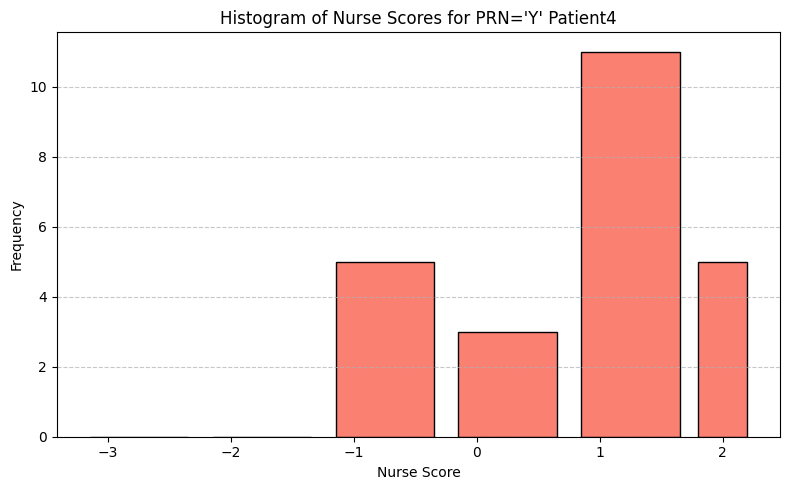

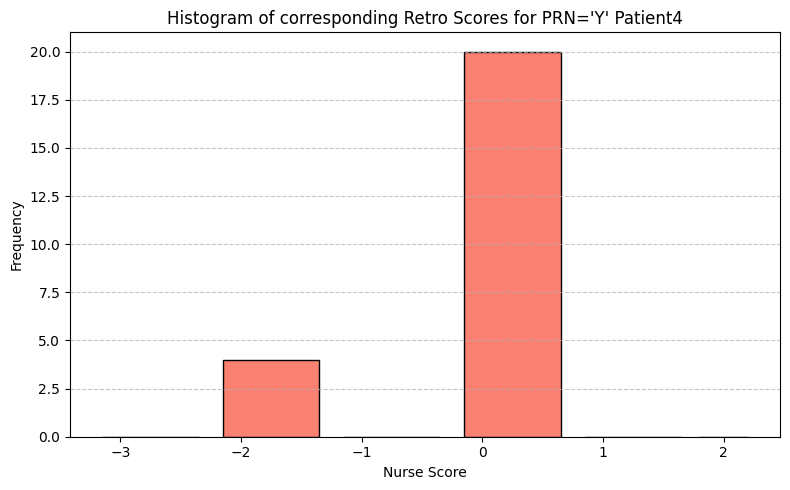

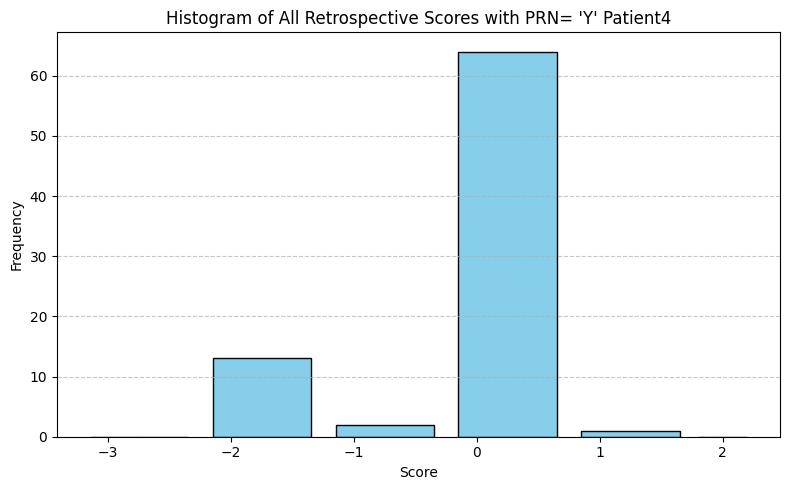

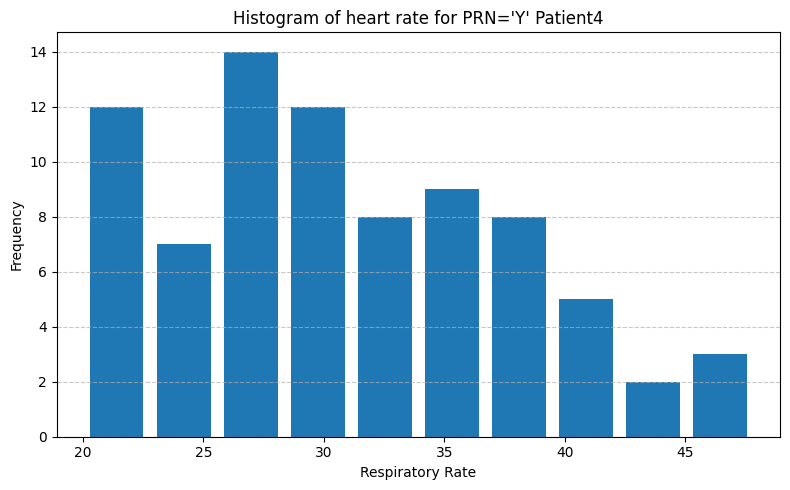

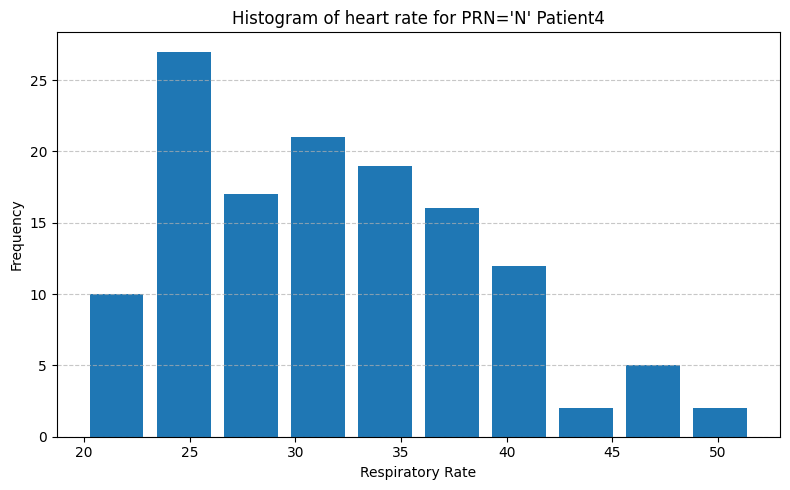

In [37]:
from dateutil.parser import parse


#Retrospective
for patient in os.listdir(data_dir):
    print(patient)
    if 'DS' in patient:
        continue
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):

        #Vitals Data
        vitals_file_path = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_{Tag}.mat')
        if not os.path.isfile(vitals_file_path):
            continue
        vitals_data = loadmat(vitals_file_path)
        hr = vitals_data["heart_rate"]

        # time = vitals_data['start_time'].flatten()
        sbs = vitals_data['sbs'].flatten()
        x_mag = vitals_data["x_mag"]
        retro_PRN = vitals_data['PRNs'].flatten()
        resp = vitals_data["respiratory_rate"]
        times_sbs = vitals_data['start_time'].flatten()

        # Remove all white spaces from each string
        retro_PRN = [s.replace(" ", "") for s in retro_PRN]

        Times = []
        PRNs = [] #Need retrospective ecg data to use PRN info
        SBS = []
        signal_NoPRN = []
        signal_YesPRN = []
        Retro_Scores_PRN = []        

        for i in range(len(sbs) - 1):
            if(retro_PRN[i] != 'nan') and (np.mean(resp[i]) != 0):
                PRNs.append(retro_PRN[i])
                resp_signal = resp[i]
                SBS.append(sbs[i])
                accel_signal = x_mag[i]
                accel_signal = Actigraph_Metrics.VecMag_MAD(accel_signal, window=100)
                Times.append(times_sbs[i])
                hr_signal = hr[i] 
                signal = np.mean(resp_signal)
                if retro_PRN[i] == 'N':
                    signal_NoPRN.append(signal) 
                elif retro_PRN[i] == 'Y':
                    signal_YesPRN.append(signal)
                    Retro_Scores_PRN.append(sbs[i])

    #Find corresponding scores in Nurse PRN
    print('Loading SBS data')
    s = f"_SBS_Scores.xlsx"
    sbs_file = os.path.join(patient_dir, patient + s)
    if not os.path.isfile(sbs_file):
        print(f"SBS File not found for path {sbs_file}")
        continue 

    nurse_data, epic_names = load_from_excel(sbs_file)

    # Extract nurse score times and values
    nurse_times = nurse_data['Time']
    nurse_scores = nurse_data['SBS']  # or whatever the score column is called

    # Ensure datetime format (adjust if needed)
    if isinstance(nurse_times[0], str):
        nurse_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in nurse_times]

    # Same for retrospective Times
    retro_times_Y = [t for prn, t in zip(PRNs, Times) if prn == 'Y']
    # if isinstance(retro_times_Y[0], float) or isinstance(retro_times_Y[0], np.float64):
    #     retro_times_Y = [parse(t) if isinstance(t, str) else t for t in retro_times_Y]
    if isinstance(retro_times_Y, str):
            retro_times_Y = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%S') for t in retro_times_Y]

    # Create a dictionary with tolerance for time matching
    retro_time_score_pairs = [(t, s) for t, s in zip(Times, SBS) if t in retro_times_Y]

    # Extract nurse scores and matching retrospective scores within ±10 minutes
    nurse_scores_within_10min = []
    retro_match = []

    for retro_t in retro_times_Y:
        # Convert to datetime if needed
        if isinstance(retro_t, str):
            retro_t = datetime.strptime(retro_t, '%Y-%m-%dT%H:%M:%S')
        elif isinstance(retro_t, (float, np.float64)):
            retro_t = datetime.fromtimestamp(retro_t)
        
        # Find closest retrospective score (within 10 minutes)
        closest_score = None
        closest_diff = float('inf')
        
        for t_nurse, s_nurse in zip(nurse_times, nurse_scores):
            # Convert nurse time to datetime if needed
            if isinstance(t_nurse, str):
                t_nurse = datetime.strptime(t_nurse, '%Y-%m-%d %H:%M:%S')
            
            time_diff = abs((retro_t - t_nurse).total_seconds())
            
            if time_diff <= 600:  # 10 minutes
                # Find matching retrospective score
                for t_retro, s_retro in retro_time_score_pairs:
                    if isinstance(t_retro, str):
                        t_retro = datetime.strptime(t_retro, '%Y-%m-%dT%H:%M:%S')
                    elif isinstance(t_retro, (float, np.float64)):
                        t_retro = datetime.fromtimestamp(t_retro)
                    
                    if abs((t_retro - retro_t).total_seconds()) <= 600:
                        nurse_scores_within_10min.append(s_nurse)
                        retro_match.append(s_retro)
                        break  # Found a match, move to next nurse time

    # Define custom bins centered at -3, -2, -1, 0, 1, 2
    bin_centers = np.array([-3, -2, -1, 0, 1, 2])
    bin_width = 0.5  # Adjust this to make bars skinnier or wider
    bin_edges = np.concatenate([
        bin_centers - bin_width/2, 
        [bin_centers[-1] + bin_width/2]
    ])



    if(len(nurse_scores_within_10min) > 0 or len(retro_match) > 0):
    # ===== 1. Histogram of Nurse Scores Within 10 Minutes =====
        plt.figure(figsize=(8, 5))
        plt.hist(
            nurse_scores_within_10min, 
            bins=bin_edges, 
            color='salmon', 
            edgecolor='black',
            rwidth=0.8  # Controls bar width (0.8 = 80% of bin width)
        )
        plt.title(f"Histogram of Nurse Scores for PRN='Y' {patient}")
        plt.xlabel("Nurse Score")
        plt.ylabel("Frequency")
        plt.xticks(bin_centers)  # Ensure ticks are centered
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.hist(
            retro_match, 
            bins=bin_edges, 
            color='salmon', 
            edgecolor='black',
            rwidth=0.8  # Controls bar width (0.8 = 80% of bin width)
        )
        plt.title(f"Histogram of corresponding Retro Scores for PRN='Y' {patient}")
        plt.xlabel("Nurse Score")
        plt.ylabel("Frequency")
        plt.xticks(bin_centers)  # Ensure ticks are centered
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # ===== 2. Histogram of Retro_Scores_PRN =====
    plt.figure(figsize=(8, 5))
    plt.hist(
        Retro_Scores_PRN, 
        bins=bin_edges, 
        color='skyblue', 
        edgecolor='black',
        rwidth=0.8
    )
    plt.title(f"Histogram of All Retrospective Scores with PRN= 'Y' {patient}" )
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.xticks(bin_centers)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.hist(
        signal_YesPRN, 
        rwidth=0.8
    )
    plt.title(f"Histogram of heart rate for PRN='Y' {patient}")
    plt.xlabel("Respiratory Rate")
    plt.ylabel("Frequency")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(8, 5))
    plt.hist(
        signal_NoPRN, 
        rwidth=0.8
    )
    plt.title(f"Histogram of heart rate for PRN='N' {patient}")
    plt.xlabel("Respiratory Rate")
    plt.ylabel("Frequency")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [38]:
def extract_baseline(patient_dir, patient, TIME):
    file_path = os.path.join(patient_dir, f'{patient}_SickBayData.mat')
    vitals_data = loadmat(file_path)
    vital_times_raw = vitals_data['time'].flatten()
    vital_times = []

    print('converting time data type')
    for t in vital_times_raw:
        if isinstance(t, np.ndarray):
            # probably a char array
            t_str = ''.join(chr(c) if isinstance(c, (int, np.integer)) else str(c) for c in t)
        else:
            t_str = str(t).strip()

        try:
            dt = datetime.strptime(t_str, '%m/%d/%Y %I:%M:%S %p')  # or whatever format you're using
            vital_times.append(dt)
        except ValueError as e:
            print(f"Could not parse time string: {t_str} — {e}")\
            
    if isinstance(TIME, str):
        TIME = datetime.strptime(TIME, '%Y-%m-%dT%H:%M:%S') 

    print('finished converting, extracting baselien data now')
    resp_rates = []
    heart_rates = []



    idx = 0
    for vitals_t in vital_times:

        time_diff = (TIME - vitals_t).total_seconds()
        
        if time_diff <= 43200:  # 12 hours
            resp_rates.append(vitals_data['respiratory_rate'].flatten()[idx])
            heart_rates.append(vitals_data['heart_rate'].flatten()[idx])
        idx+=1

    resp_rates = [x for x in resp_rates if np.isfinite(x)]
    heart_rates = [x for x in heart_rates if np.isfinite(x)]
    return np.mean(heart_rates), np.mean(resp_rates)

   

In [39]:
def delayed_exponential_decay(t, start, end, t0=450, rate=-0.25):
    t = np.asarray(t)
    f = np.full_like(t, fill_value=start, dtype=float)
    decay_mask = t >= t0
    f[decay_mask] = end + (start - end) * np.exp(rate * (t[decay_mask] - t0))
    return f

.DS_Store
Patient4
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


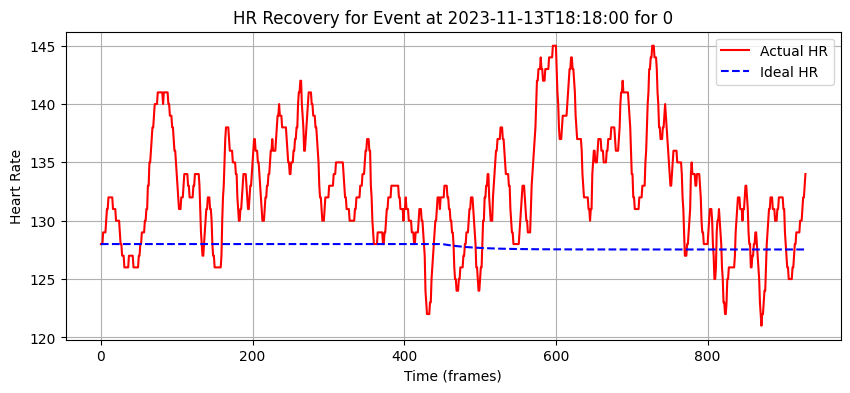

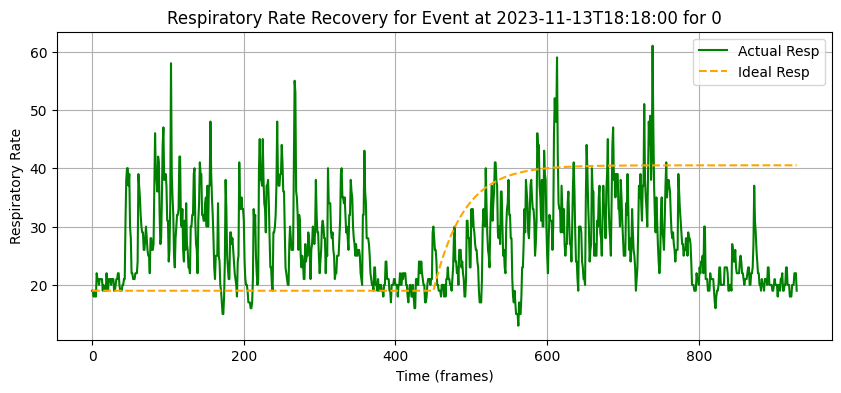


Errors for event at 2023-11-13T18:18:00:
  HR SSE: 46425.44, HR Signed Error: 4692.44
  RESP SSE: 146180.26, RESP Signed Error: -1834.64
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


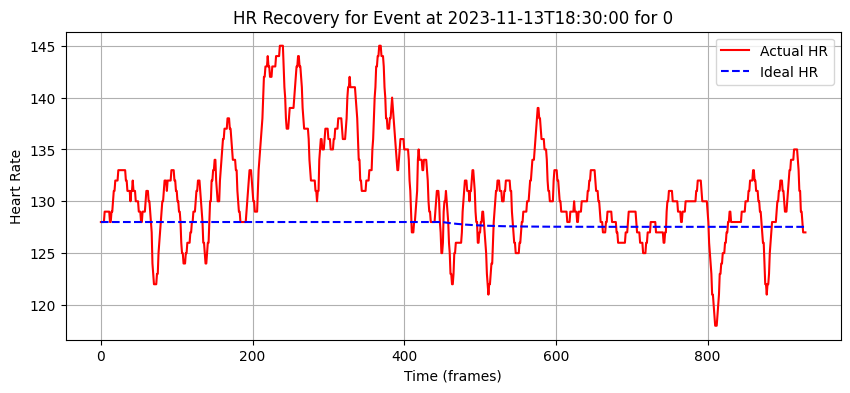

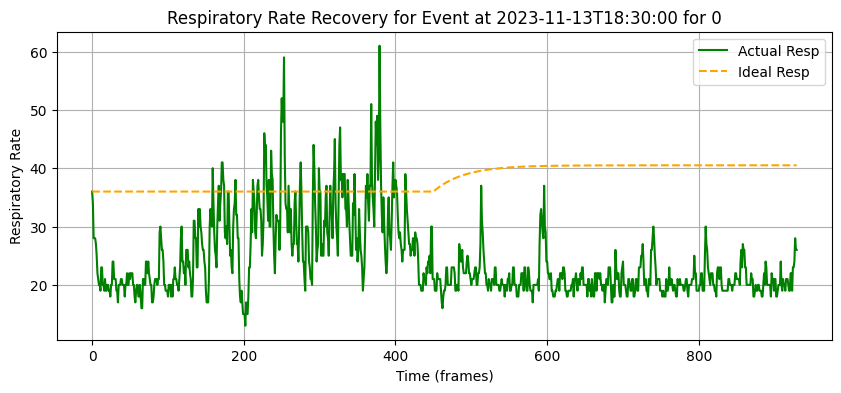


Errors for event at 2023-11-13T18:30:00:
  HR SSE: 32288.64, HR Signed Error: 3122.44
  RESP SSE: 237378.65, RESP Signed Error: -12910.17
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


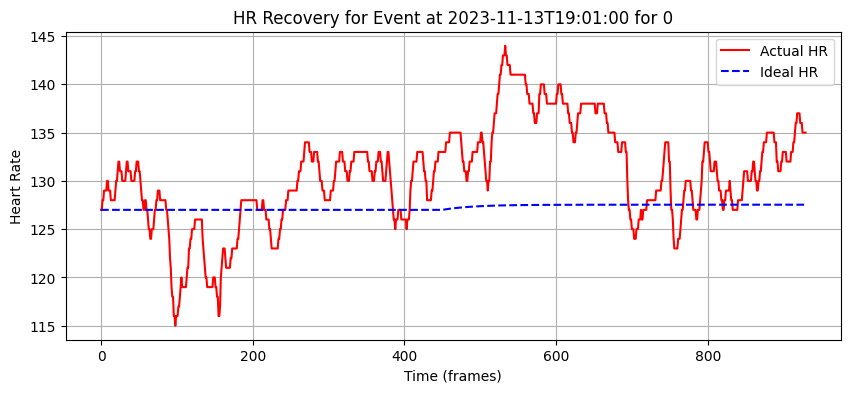

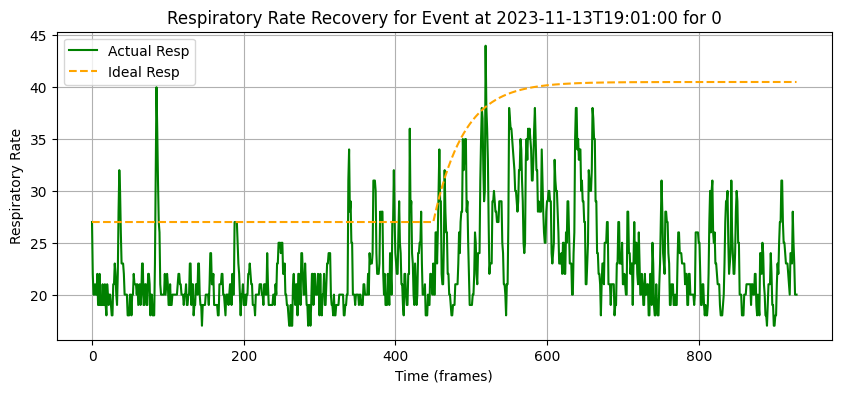


Errors for event at 2023-11-13T19:01:00:
  HR SSE: 35589.49, HR Signed Error: 3137.94
  RESP SSE: 138329.98, RESP Signed Error: -9623.65
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


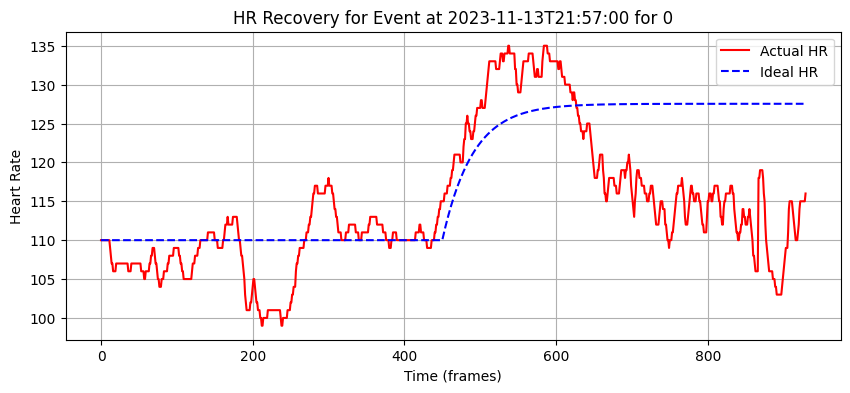

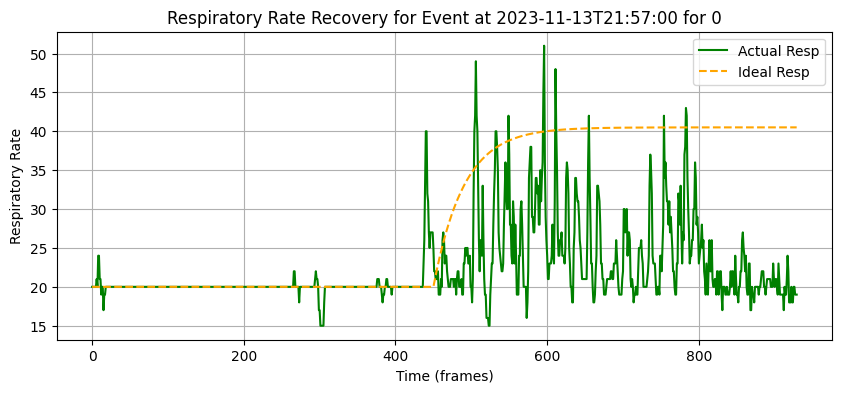


Errors for event at 2023-11-13T21:57:00:
  HR SSE: 70595.67, HR Signed Error: -3527.53
  RESP SSE: 123980.39, RESP Signed Error: -6800.14
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


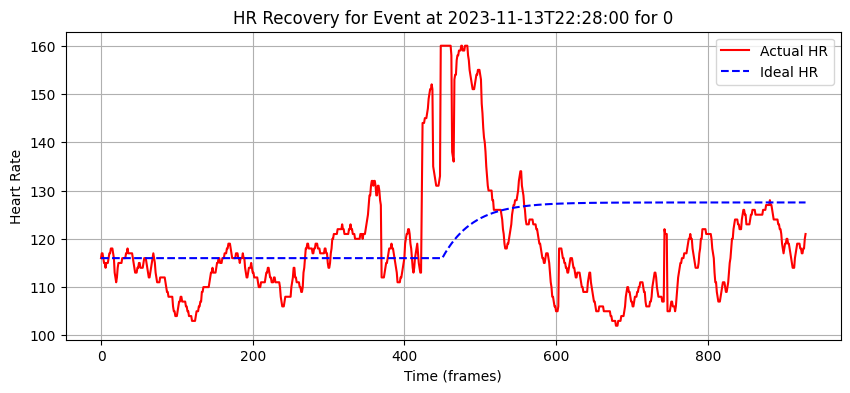

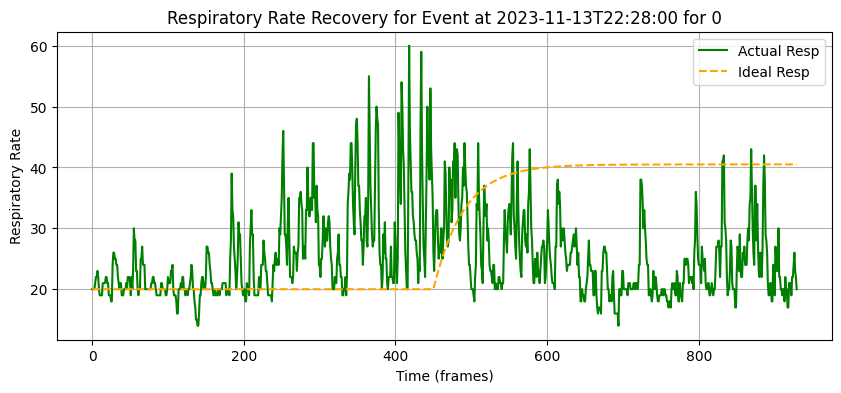


Errors for event at 2023-11-13T22:28:00:
  HR SSE: 182070.77, HR Signed Error: -2613.54
  RESP SSE: 167823.97, RESP Signed Error: -3871.14
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


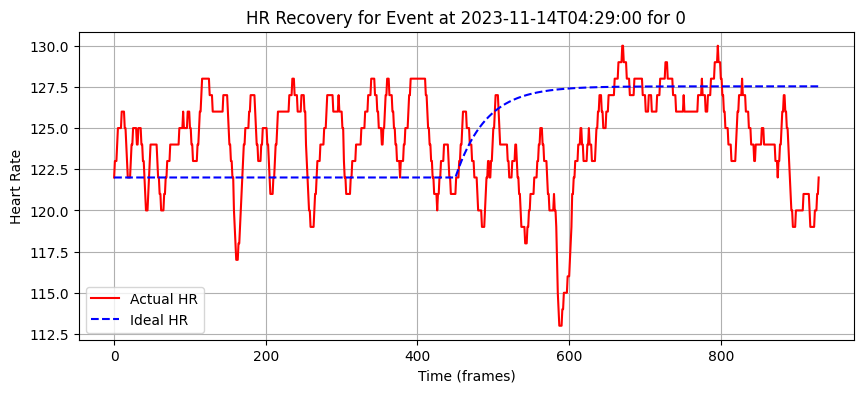

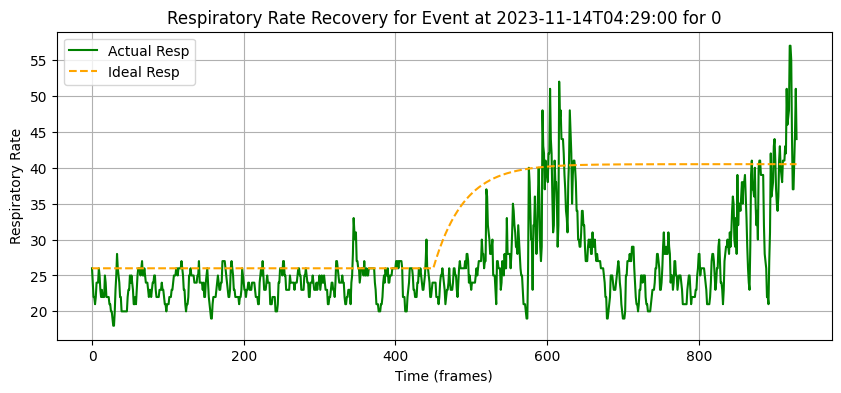


Errors for event at 2023-11-14T04:29:00:
  HR SSE: 14953.28, HR Signed Error: -343.55
  RESP SSE: 76915.75, RESP Signed Error: -5856.15
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


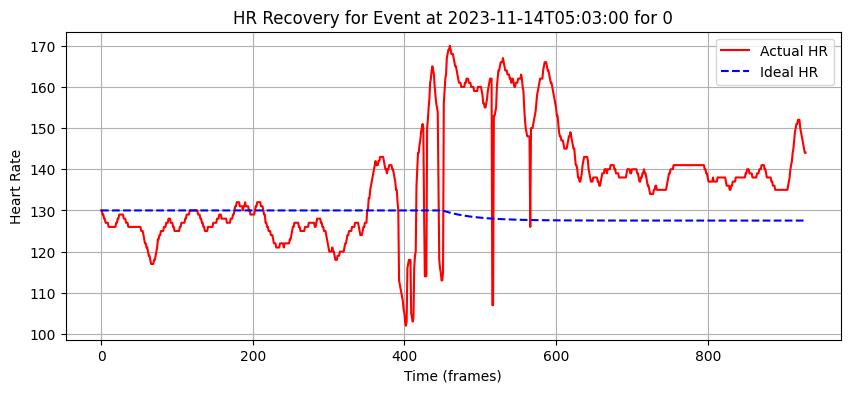

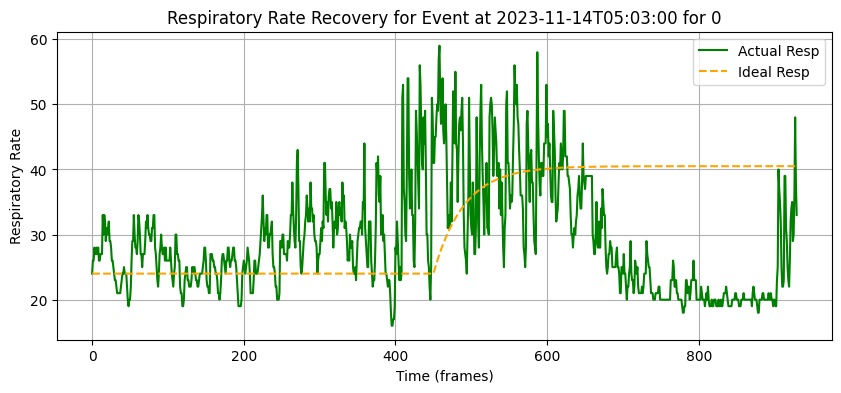


Errors for event at 2023-11-14T05:03:00:
  HR SSE: 248660.42, HR Signed Error: 7583.43
  RESP SSE: 135062.45, RESP Signed Error: -2252.15
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53484154080232
Extracted Baseline


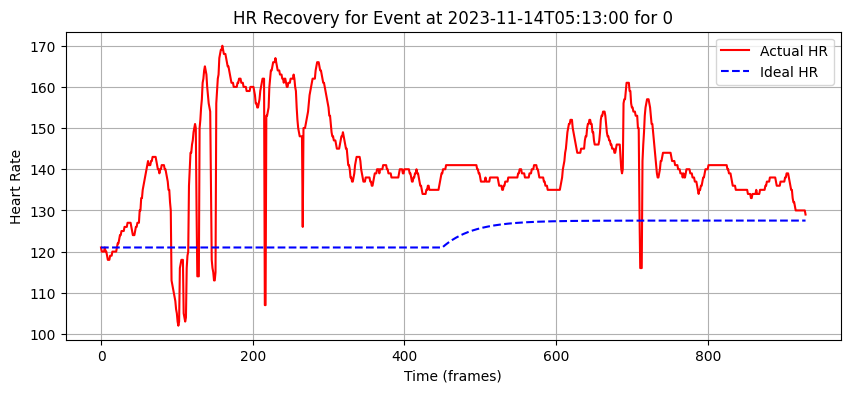

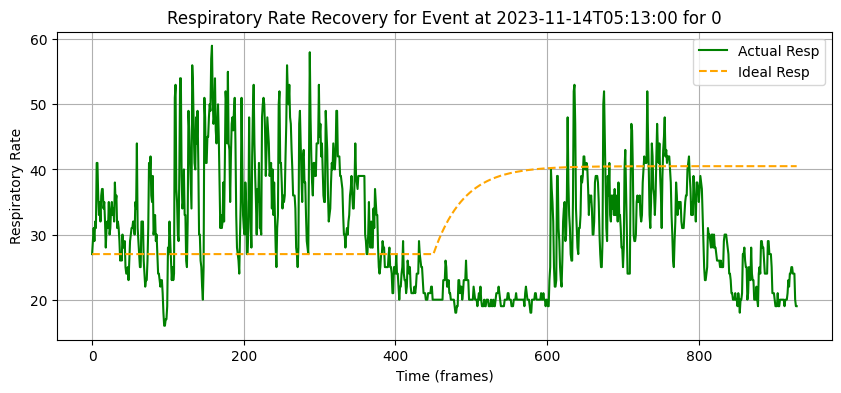


Errors for event at 2023-11-14T05:13:00:
  HR SSE: 441106.34, HR Signed Error: 16447.95
  RESP SSE: 155892.14, RESP Signed Error: -2404.65
converting time data type
finished converting, extracting baselien data now
baseline is: 127.51793433103359
Extracted Baseline


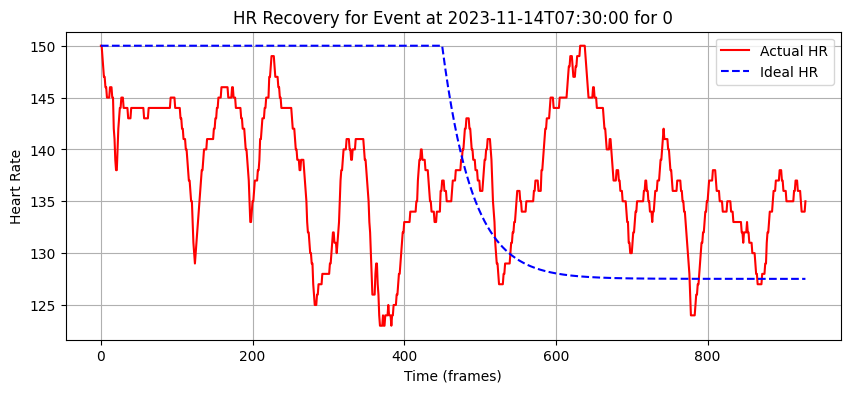

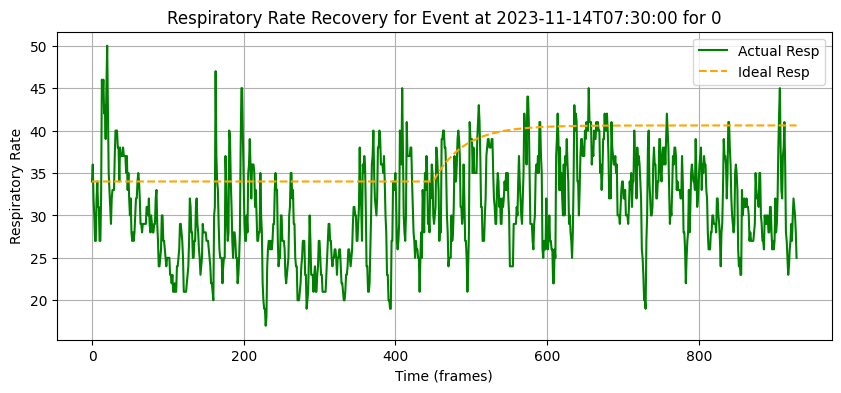


Errors for event at 2023-11-14T07:30:00:
  HR SSE: 127369.30, HR Signed Error: -1758.17
  RESP SSE: 64779.10, RESP Signed Error: -5743.98
converting time data type
finished converting, extracting baselien data now
baseline is: 127.50439193485336
Extracted Baseline


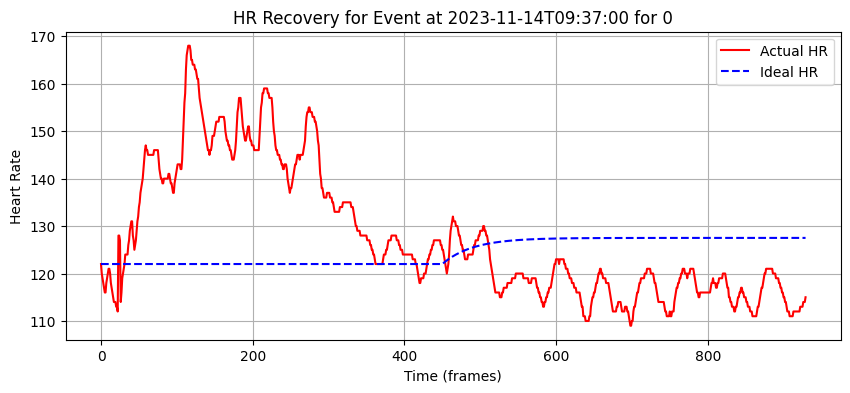

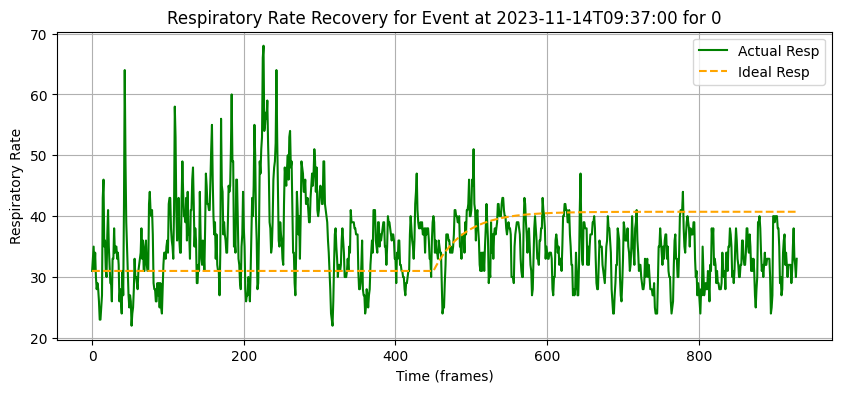


Errors for event at 2023-11-14T09:37:00:
  HR SSE: 247647.81, HR Signed Error: 2813.83
  RESP SSE: 72435.96, RESP Signed Error: -35.86
converting time data type
finished converting, extracting baselien data now
baseline is: 127.53326554397422
Extracted Baseline


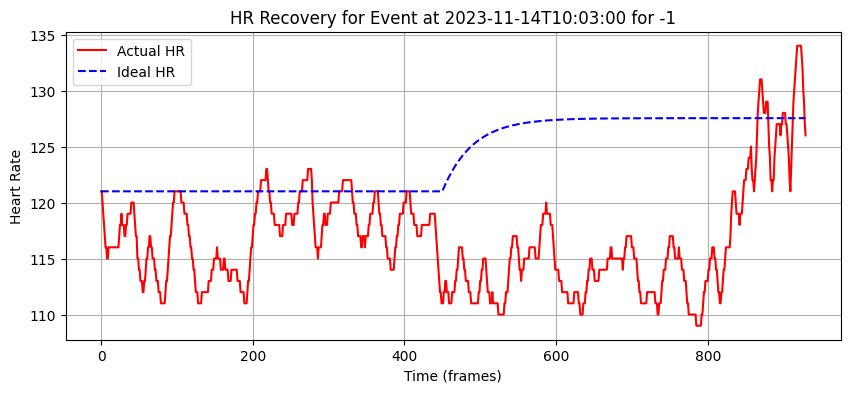

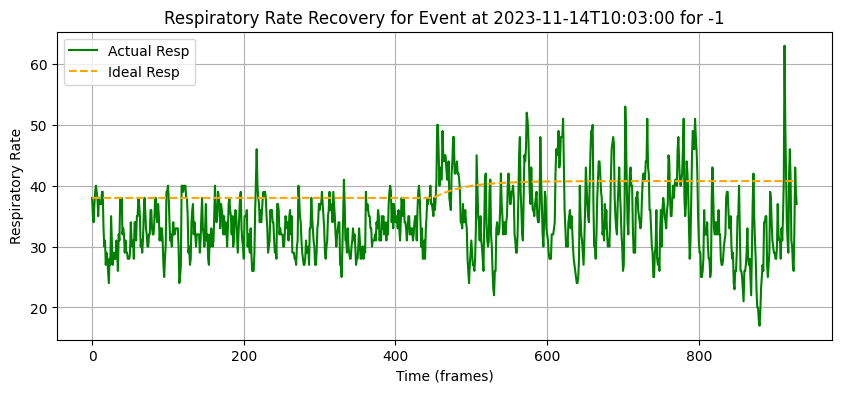


Errors for event at 2023-11-14T10:03:00:
  HR SSE: 83056.13, HR Signed Error: -6975.36
  RESP SSE: 54674.34, RESP Signed Error: -4728.43
converting time data type
finished converting, extracting baselien data now
baseline is: 127.64090896088788
Extracted Baseline


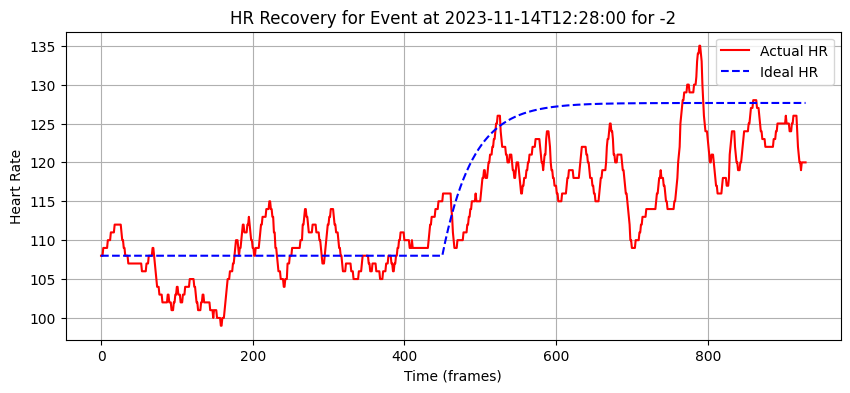

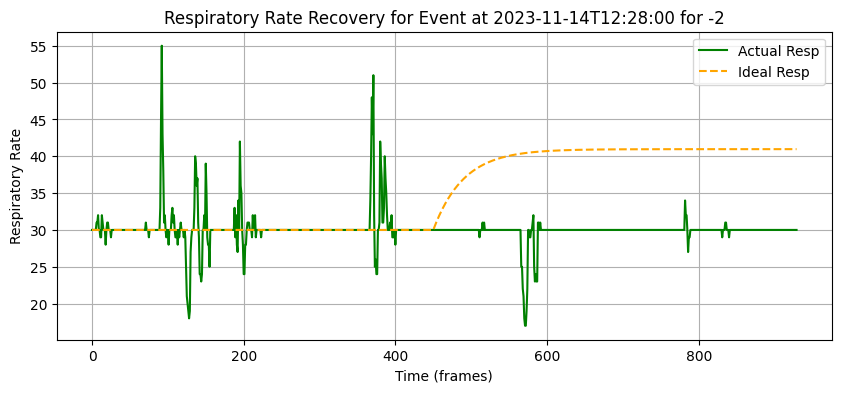


Errors for event at 2023-11-14T12:28:00:
  HR SSE: 37494.13, HR Signed Error: -3196.14
  RESP SSE: 58125.78, RESP Signed Error: -4787.42
converting time data type
finished converting, extracting baselien data now
baseline is: 127.71051046565415
Extracted Baseline


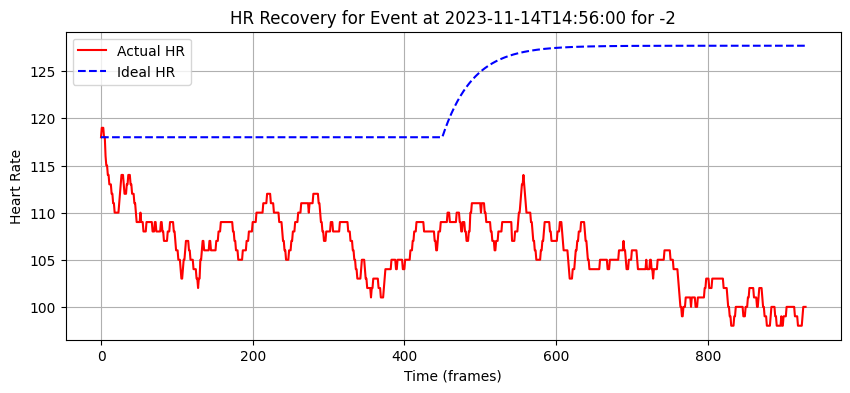

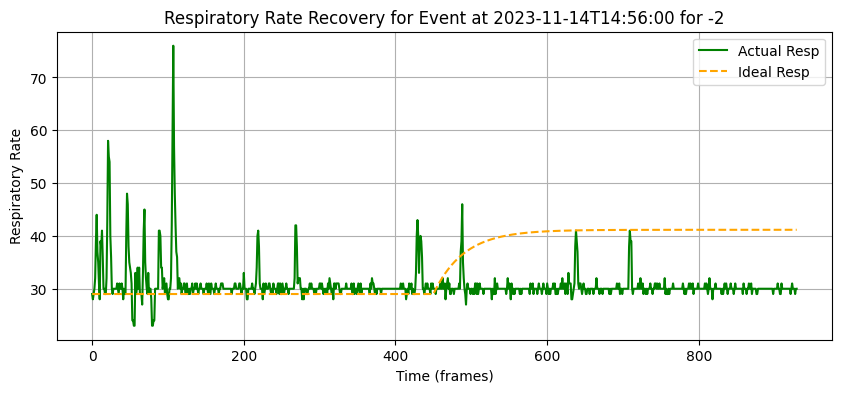


Errors for event at 2023-11-14T14:56:00:
  HR SSE: 300143.52, HR Signed Error: -15243.75
  RESP SSE: 63553.37, RESP Signed Error: -3736.74
converting time data type
finished converting, extracting baselien data now
baseline is: 127.65547409992874
Extracted Baseline


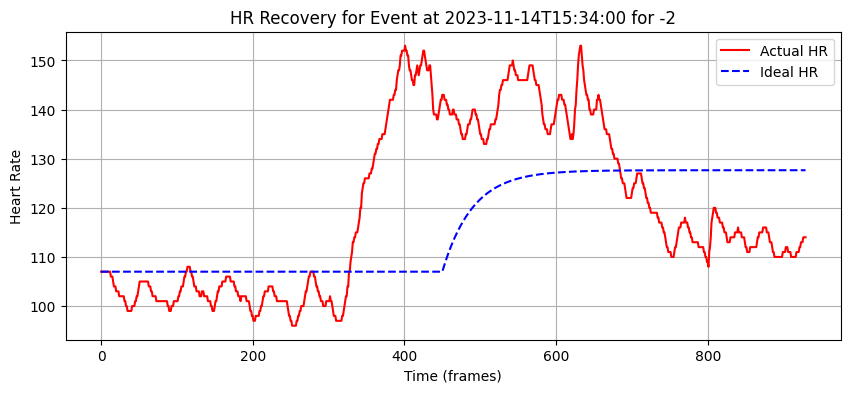

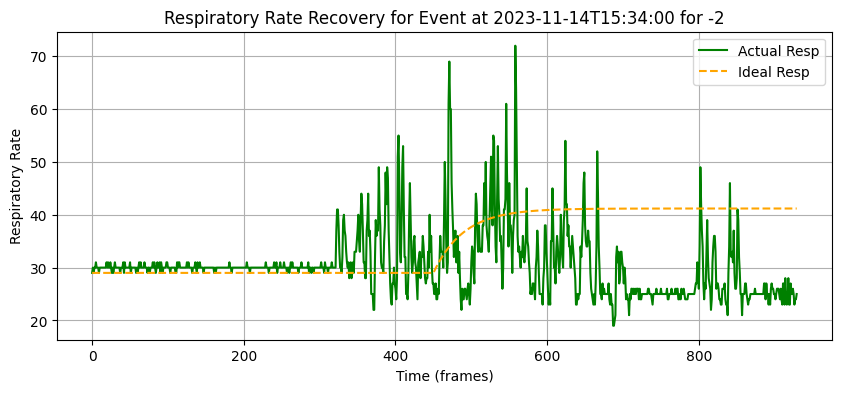


Errors for event at 2023-11-14T15:34:00:
  HR SSE: 256702.86, HR Signed Error: 2904.96
  RESP SSE: 94158.74, RESP Signed Error: -3938.45
converting time data type
finished converting, extracting baselien data now
baseline is: 127.6393020075753
Extracted Baseline


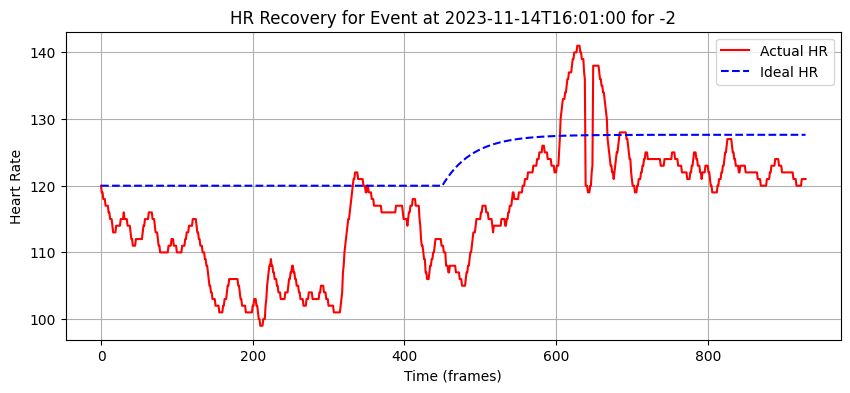

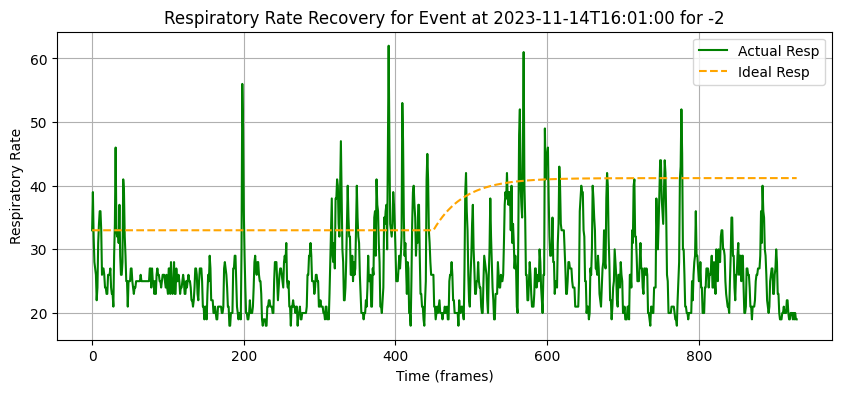


Errors for event at 2023-11-14T16:01:00:
  HR SSE: 92203.52, HR Signed Error: -6895.46
  RESP SSE: 150886.22, RESP Signed Error: -9643.90
converting time data type
finished converting, extracting baselien data now
baseline is: 127.64766709924683
Extracted Baseline


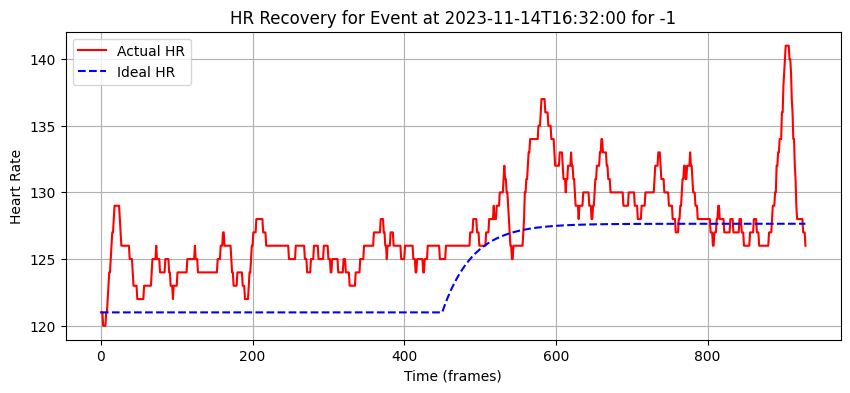

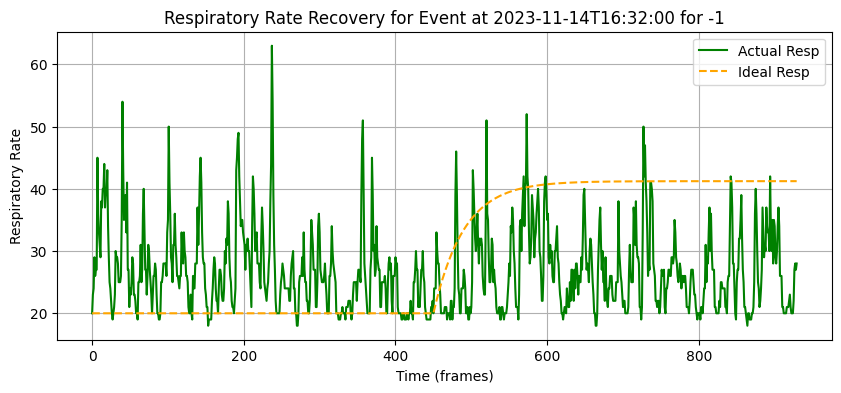


Errors for event at 2023-11-14T16:32:00:
  HR SSE: 15234.29, HR Signed Error: 2964.36
  RESP SSE: 142836.94, RESP Signed Error: -2941.21
converting time data type
finished converting, extracting baselien data now
baseline is: 127.61976734250455
Extracted Baseline


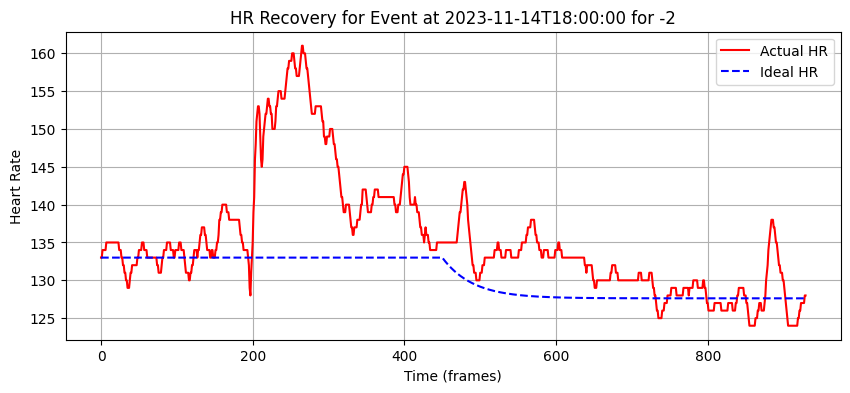

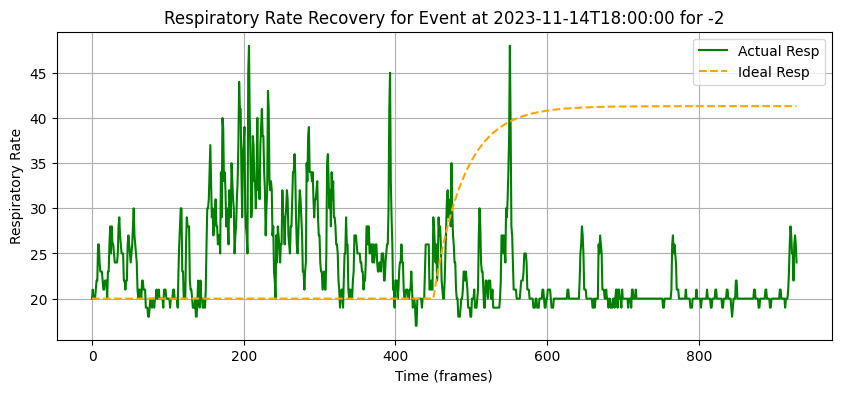


Errors for event at 2023-11-14T18:00:00:
  HR SSE: 64218.72, HR Signed Error: 4678.60
  RESP SSE: 207229.62, RESP Signed Error: -6178.58
converting time data type
finished converting, extracting baselien data now
baseline is: 127.64248697038445
Extracted Baseline


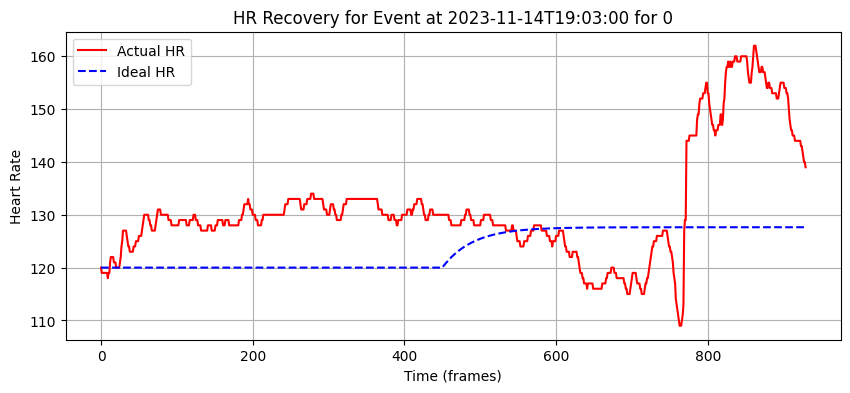

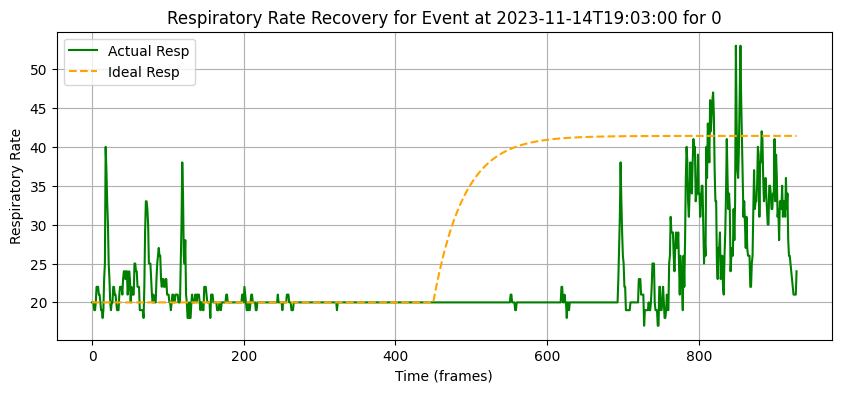


Errors for event at 2023-11-14T19:03:00:
  HR SSE: 161388.23, HR Signed Error: 7069.14
  RESP SSE: 137856.06, RESP Signed Error: -6940.56
converting time data type
finished converting, extracting baselien data now
baseline is: 127.56066697880205
Extracted Baseline


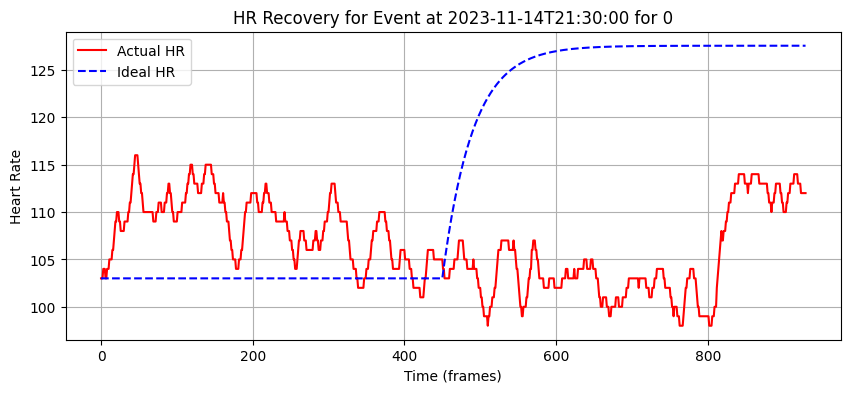

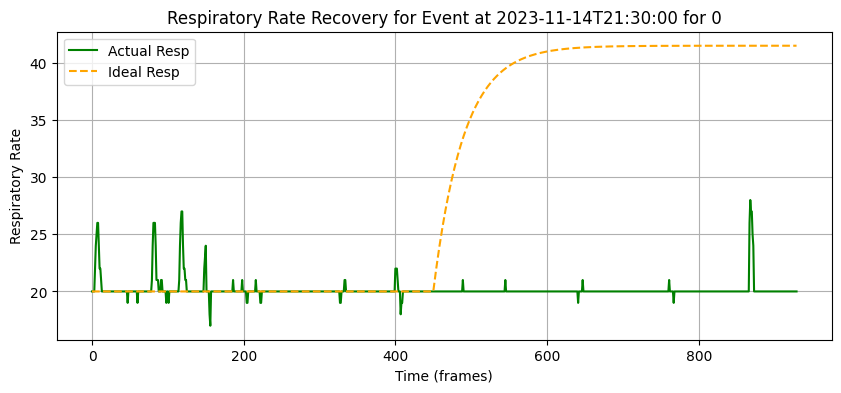


Errors for event at 2023-11-14T21:30:00:
  HR SSE: 242419.11, HR Signed Error: -7490.37
  RESP SSE: 193071.65, RESP Signed Error: -9309.90
converting time data type
finished converting, extracting baselien data now
baseline is: 127.62022433794863
Extracted Baseline


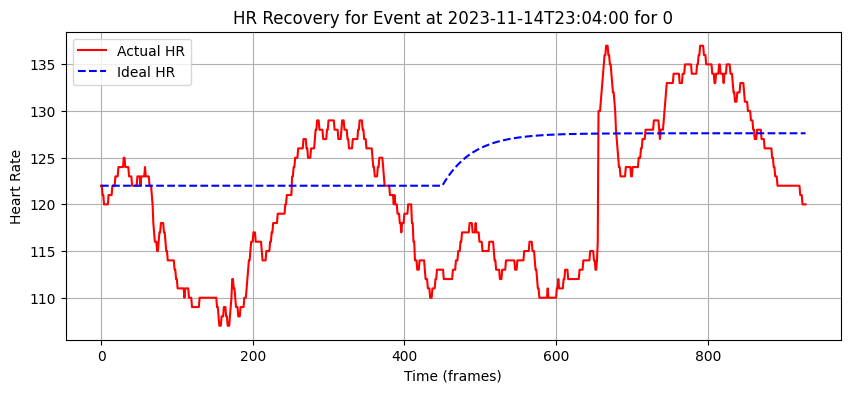

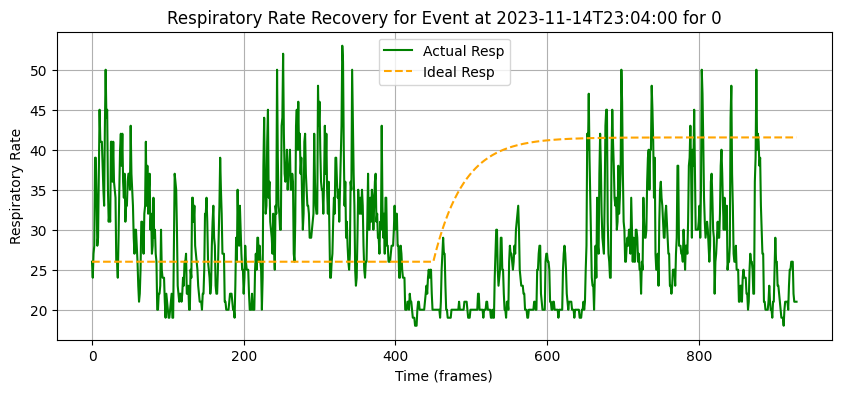


Errors for event at 2023-11-14T23:04:00:
  HR SSE: 67933.04, HR Signed Error: -3689.08
  RESP SSE: 143133.07, RESP Signed Error: -4958.80
converting time data type
finished converting, extracting baselien data now
baseline is: 127.62022433794863
Extracted Baseline


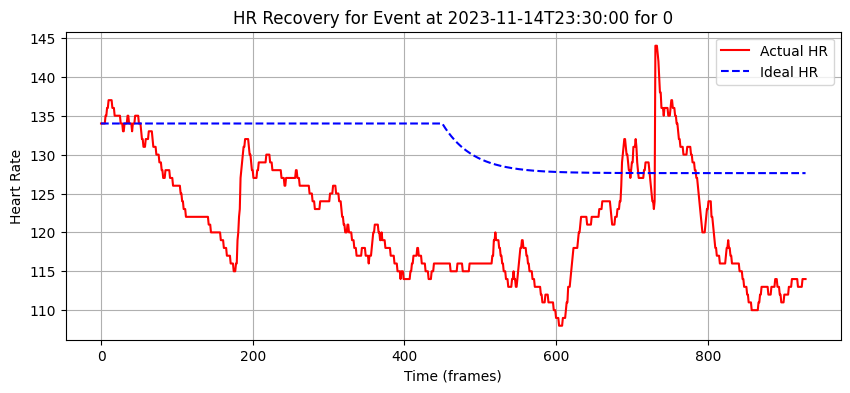

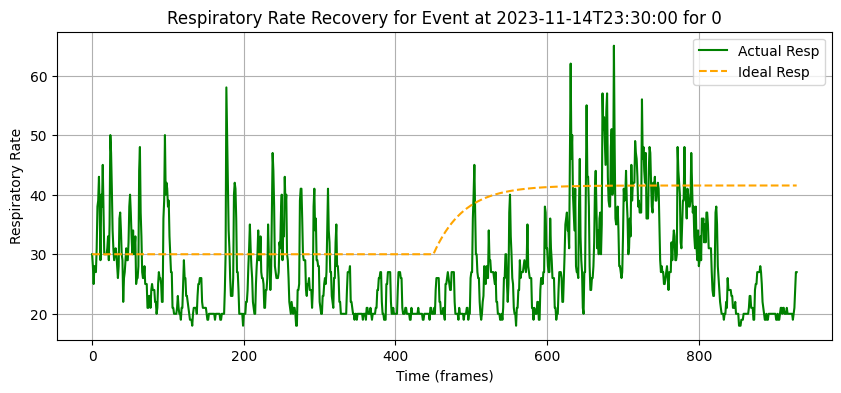


Errors for event at 2023-11-14T23:30:00:
  HR SSE: 130815.14, HR Signed Error: -8778.10
  RESP SSE: 130157.93, RESP Signed Error: -7466.80
converting time data type
finished converting, extracting baselien data now
baseline is: 127.64671031104739
Extracted Baseline


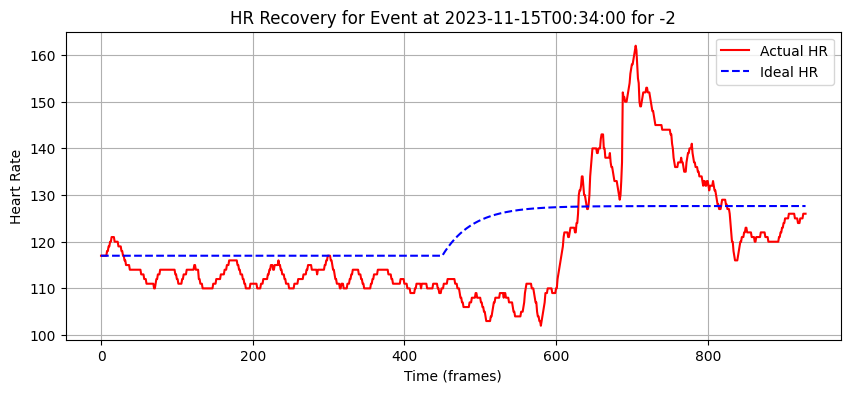

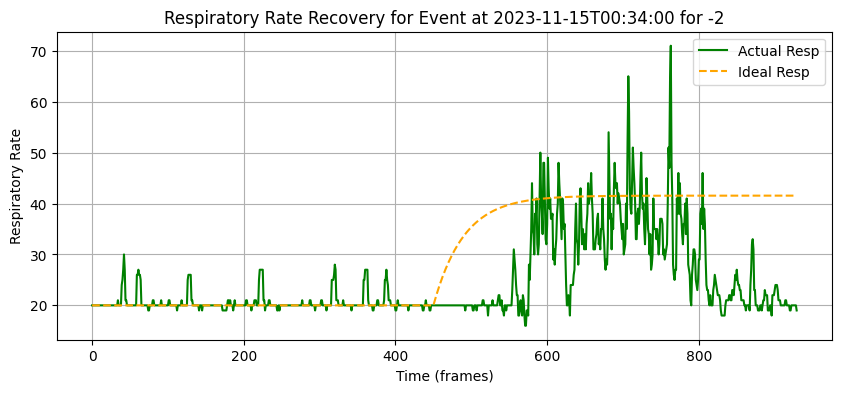


Errors for event at 2023-11-15T00:34:00:
  HR SSE: 106630.30, HR Signed Error: -2873.21
  RESP SSE: 103521.56, RESP Signed Error: -5309.31
converting time data type
finished converting, extracting baselien data now
baseline is: 127.86647168804095
Extracted Baseline


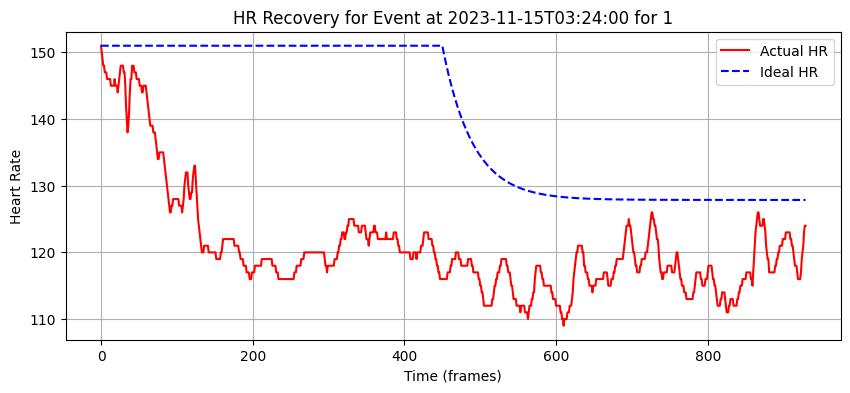

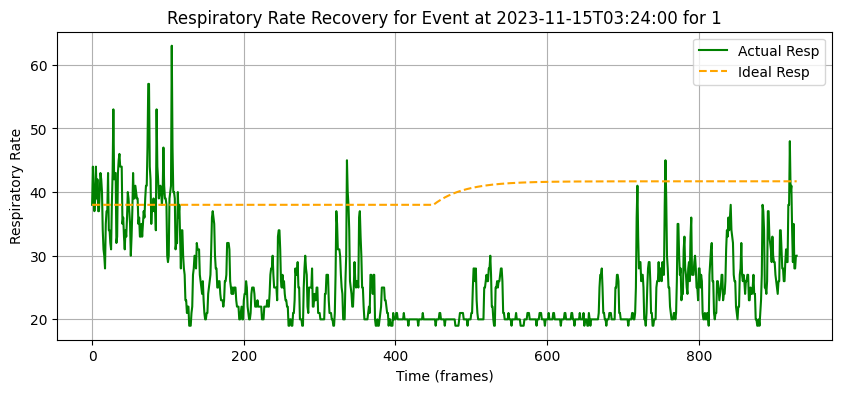


Errors for event at 2023-11-15T03:24:00:
  HR SSE: 432372.01, HR Signed Error: -17770.86
  RESP SSE: 239500.11, RESP Signed Error: -13143.43
converting time data type
finished converting, extracting baselien data now
baseline is: 127.92651727810741
Extracted Baseline


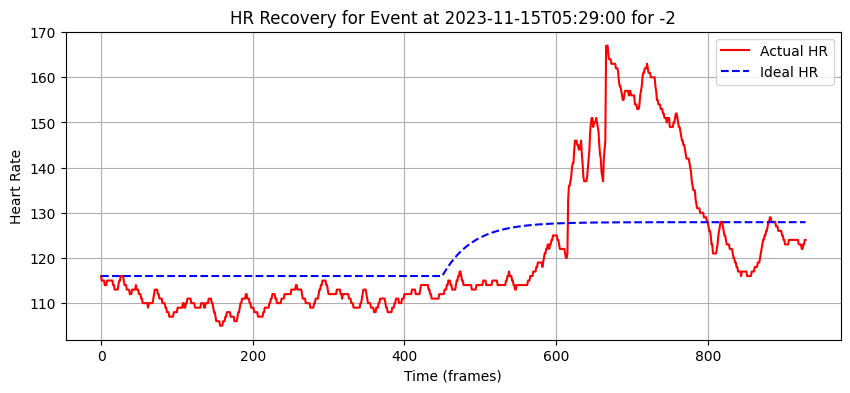

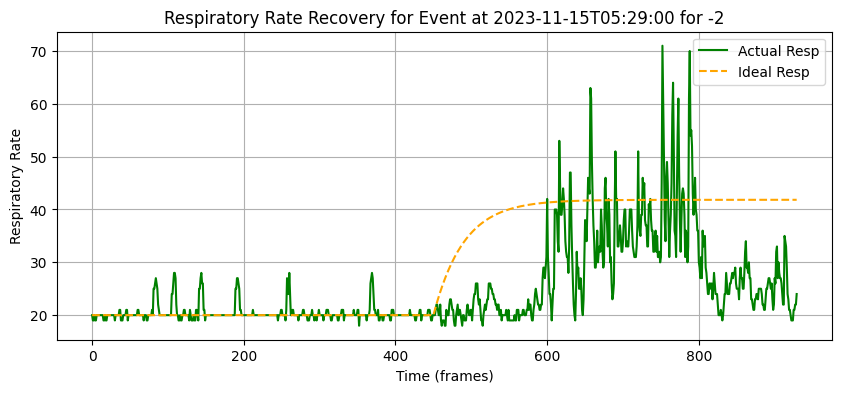


Errors for event at 2023-11-15T05:29:00:
  HR SSE: 135616.93, HR Signed Error: -609.68
  RESP SSE: 96765.83, RESP Signed Error: -5075.38
converting time data type
finished converting, extracting baselien data now
baseline is: 127.87743276227023
Extracted Baseline


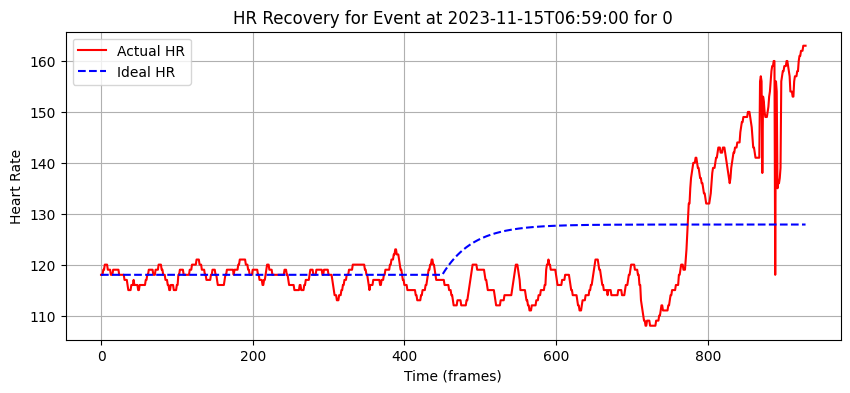

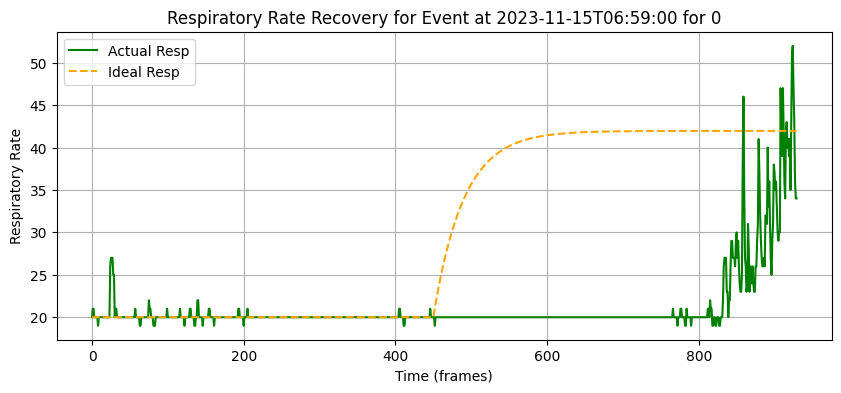


Errors for event at 2023-11-15T06:59:00:
  HR SSE: 114736.17, HR Signed Error: -1028.11
  RESP SSE: 171660.97, RESP Signed Error: -8493.88
converting time data type
finished converting, extracting baselien data now
baseline is: 127.84814284271086
Extracted Baseline


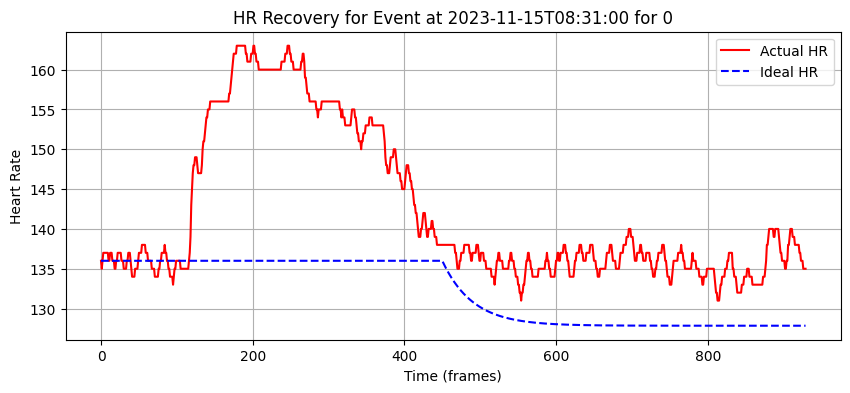

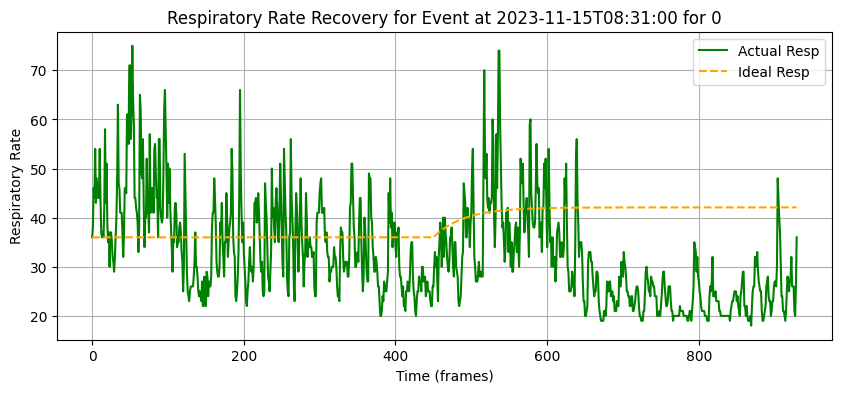


Errors for event at 2023-11-15T08:31:00:
  HR SSE: 147089.57, HR Signed Error: 9350.73
  RESP SSE: 159529.86, RESP Signed Error: -5661.27
converting time data type
finished converting, extracting baselien data now
baseline is: 127.84340343324237
Extracted Baseline


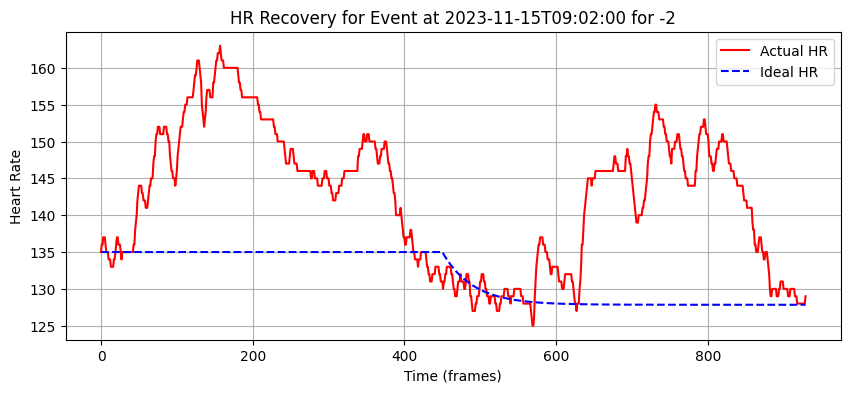

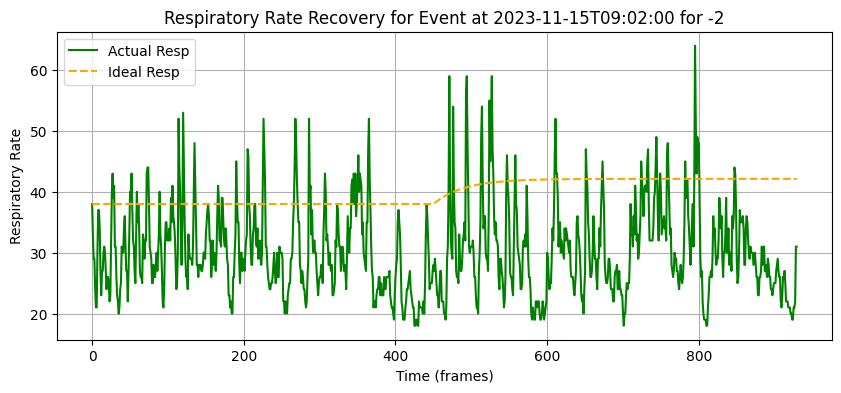


Errors for event at 2023-11-15T09:02:00:
  HR SSE: 178948.44, HR Signed Error: 9977.31
  RESP SSE: 138956.59, RESP Signed Error: -8926.95
converting time data type
finished converting, extracting baselien data now
baseline is: 127.94614477643546
Extracted Baseline


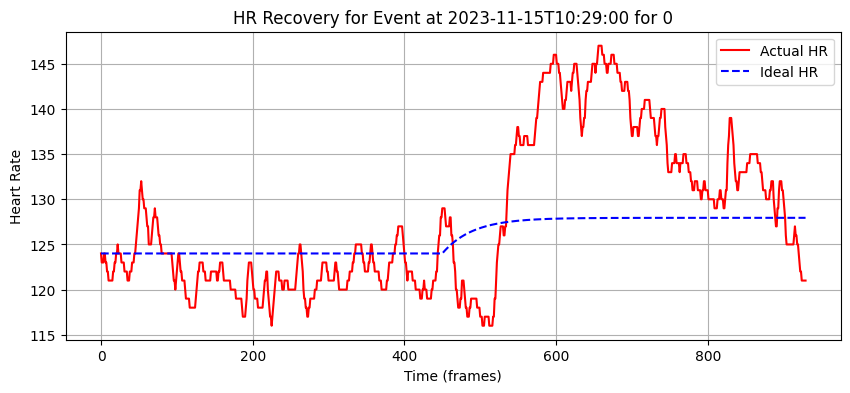

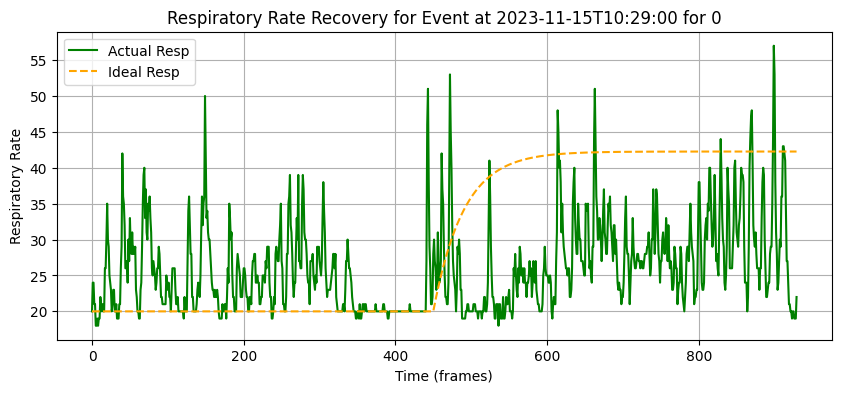


Errors for event at 2023-11-15T10:29:00:
  HR SSE: 52742.93, HR Signed Error: 1971.68
  RESP SSE: 123791.66, RESP Signed Error: -4112.39
converting time data type
finished converting, extracting baselien data now
baseline is: 127.96426914639612
Extracted Baseline


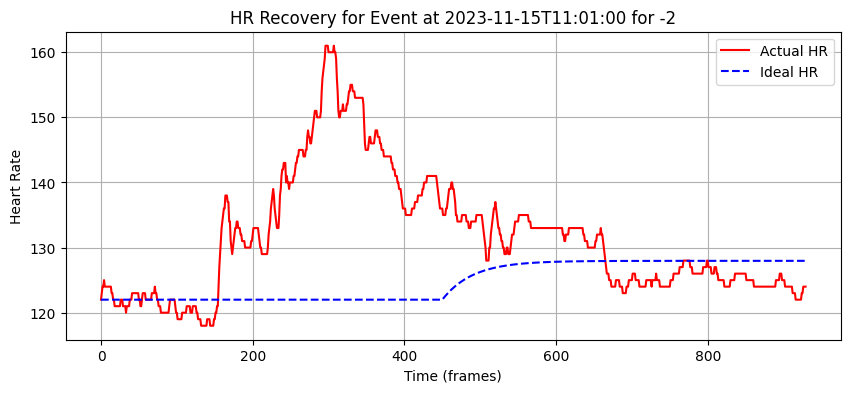

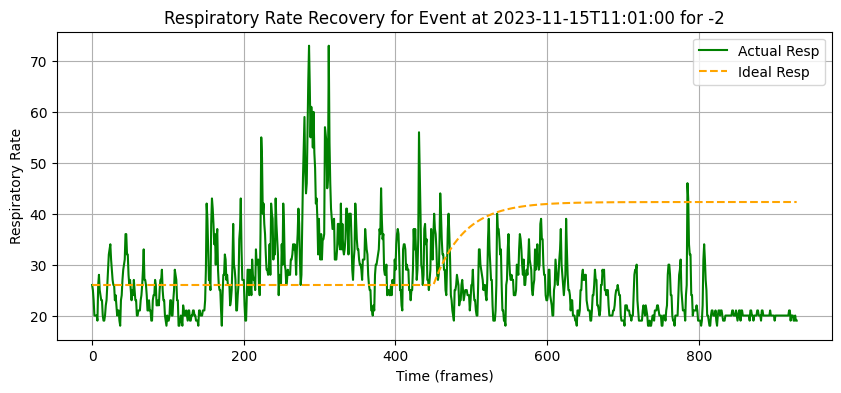


Errors for event at 2023-11-15T11:01:00:
  HR SSE: 153305.34, HR Signed Error: 6318.71
  RESP SSE: 206040.68, RESP Signed Error: -6282.64
converting time data type
finished converting, extracting baselien data now
baseline is: 128.06988395643182
Extracted Baseline


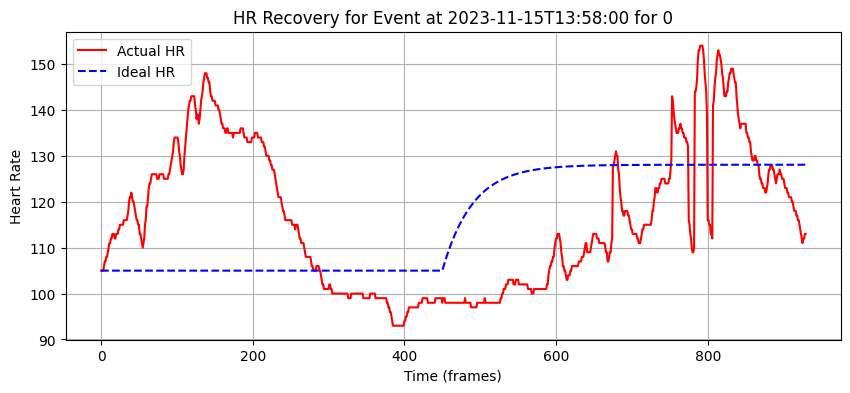

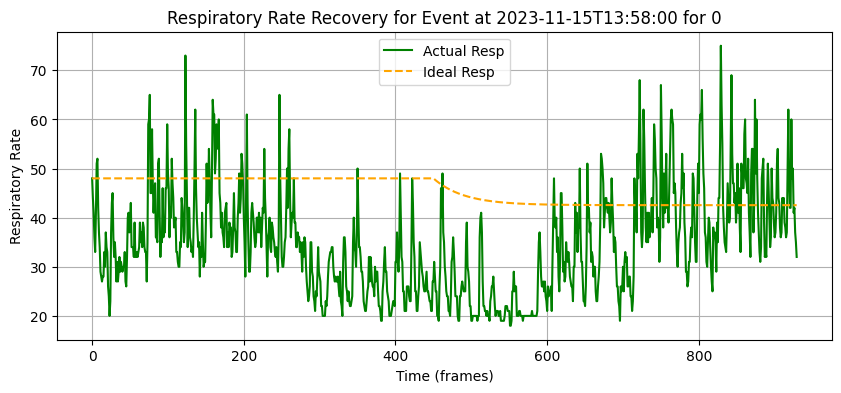


Errors for event at 2023-11-15T13:58:00:
  HR SSE: 309113.40, HR Signed Error: 153.83
  RESP SSE: 221331.64, RESP Signed Error: -9927.80
converting time data type
finished converting, extracting baselien data now
baseline is: 128.09331482261152
Extracted Baseline


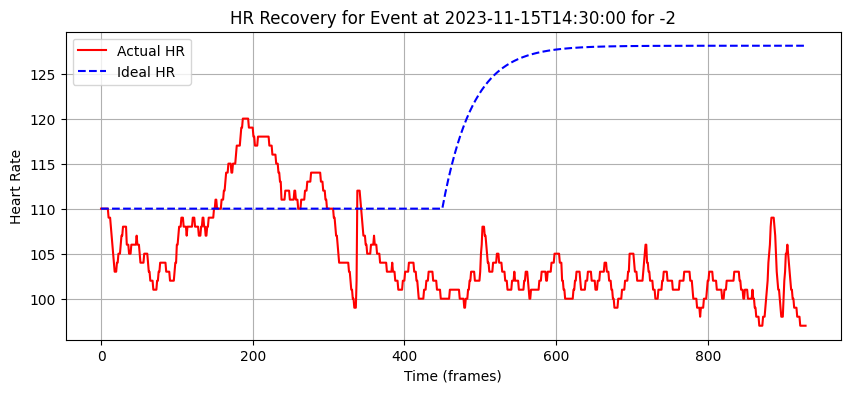

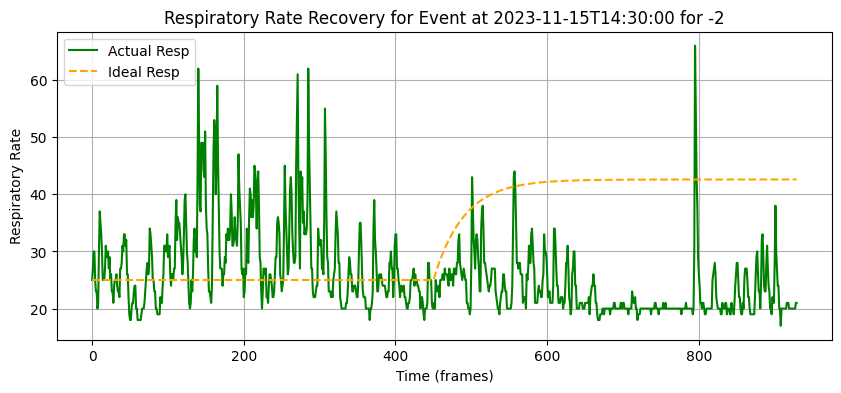


Errors for event at 2023-11-15T14:30:00:
  HR SSE: 317741.23, HR Signed Error: -12777.98
  RESP SSE: 208219.59, RESP Signed Error: -7003.02
converting time data type
finished converting, extracting baselien data now
baseline is: 128.13888055543651
Extracted Baseline


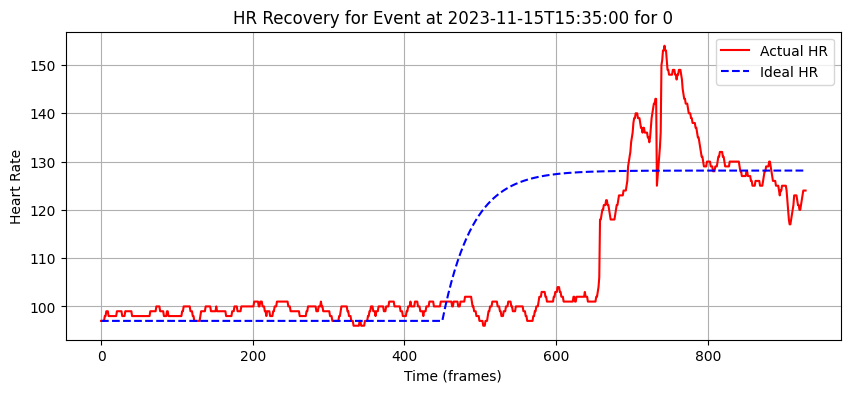

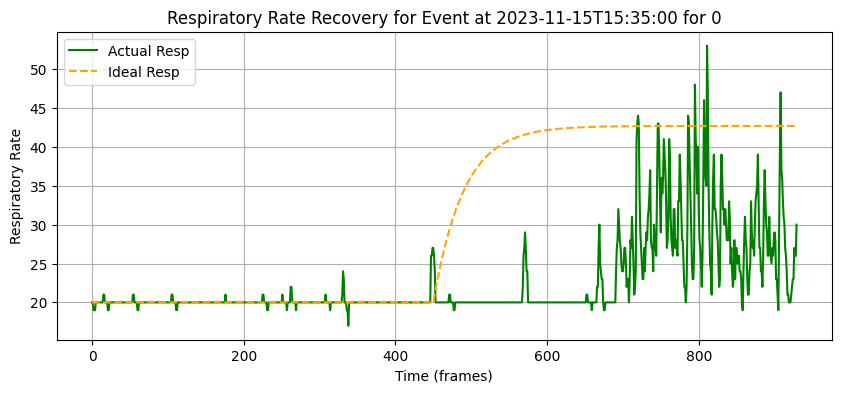


Errors for event at 2023-11-15T15:35:00:
  HR SSE: 135709.39, HR Signed Error: -2825.48
  RESP SSE: 143190.07, RESP Signed Error: -7649.24
converting time data type
finished converting, extracting baselien data now
baseline is: 128.1554247230418
Extracted Baseline


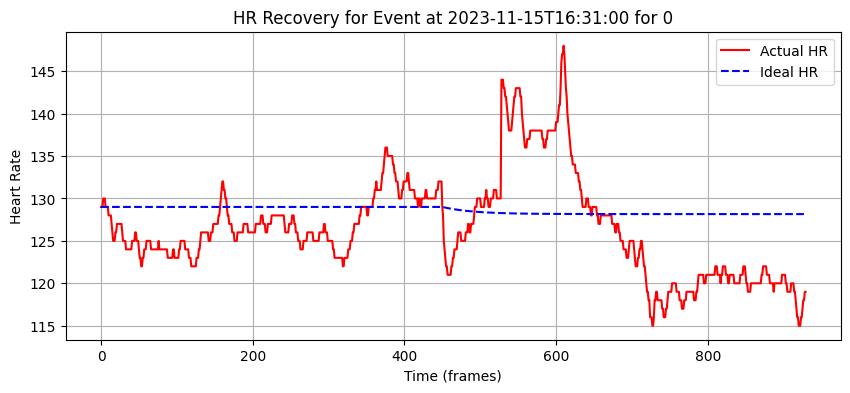

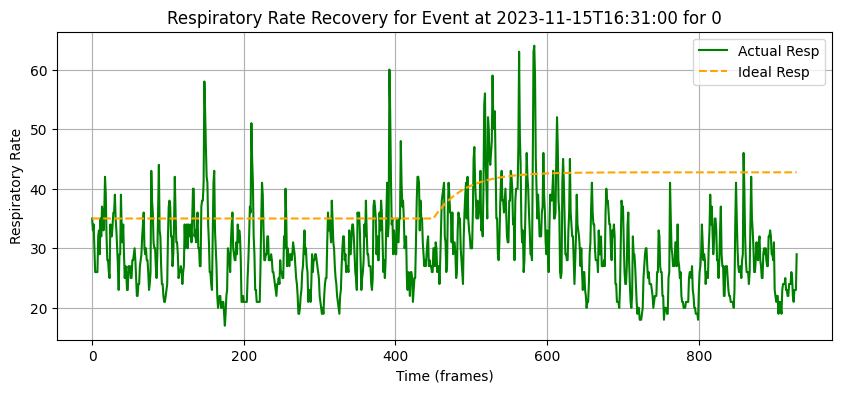


Errors for event at 2023-11-15T16:31:00:
  HR SSE: 37303.07, HR Signed Error: -1897.81
  RESP SSE: 126709.68, RESP Signed Error: -7912.52
converting time data type
finished converting, extracting baselien data now
baseline is: 128.10730119361338
Extracted Baseline


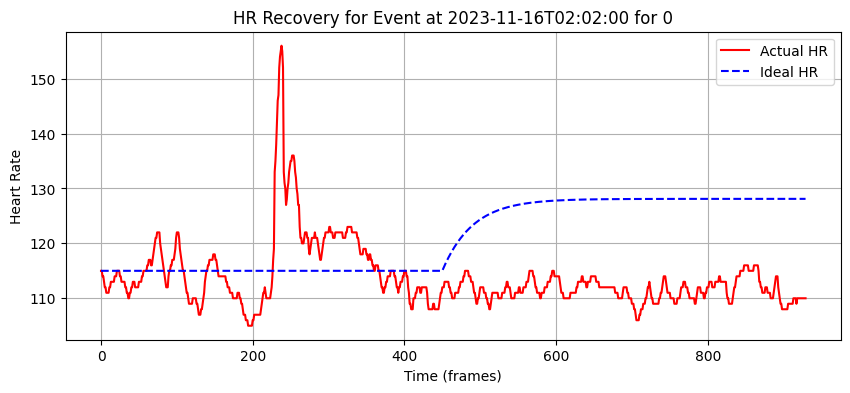

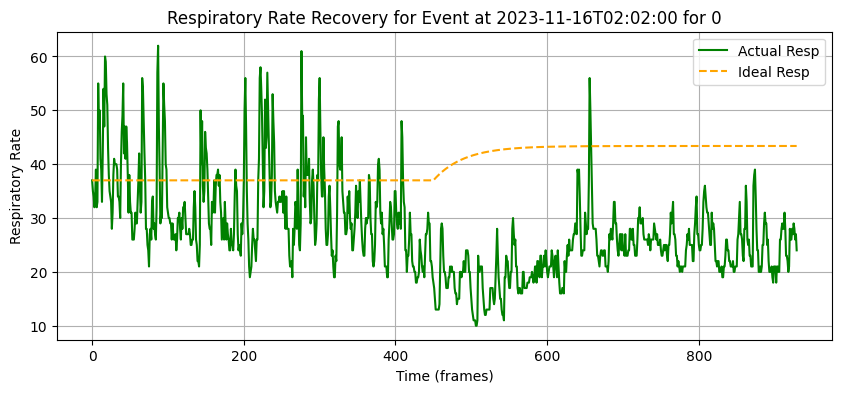


Errors for event at 2023-11-16T02:02:00:
  HR SSE: 148456.28, HR Signed Error: -6922.63
  RESP SSE: 243736.10, RESP Signed Error: -11469.29
converting time data type
finished converting, extracting baselien data now
baseline is: 128.2014022464271
Extracted Baseline


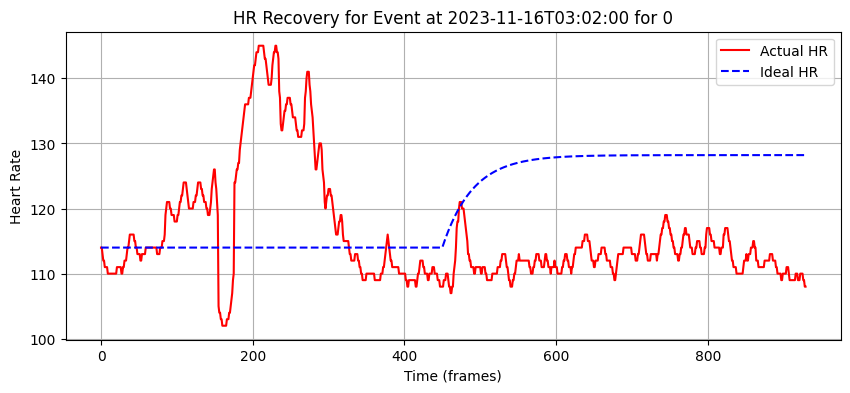

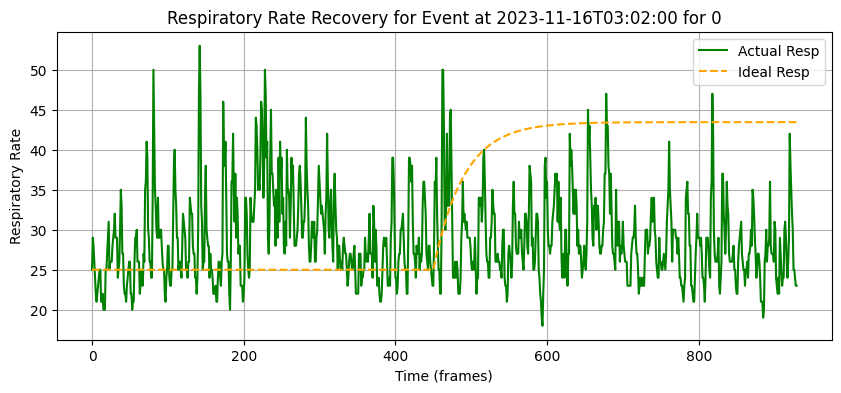


Errors for event at 2023-11-16T03:02:00:
  HR SSE: 176646.53, HR Signed Error: -4458.49
  RESP SSE: 126414.00, RESP Signed Error: -4397.25
converting time data type
finished converting, extracting baselien data now
baseline is: 128.26704246950743
Extracted Baseline


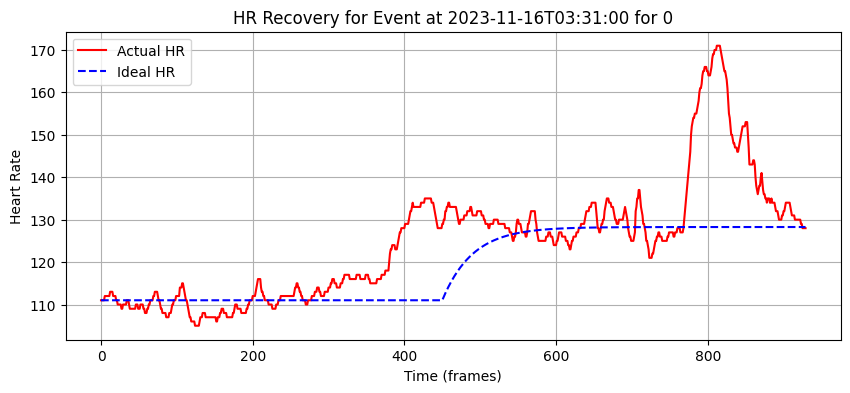

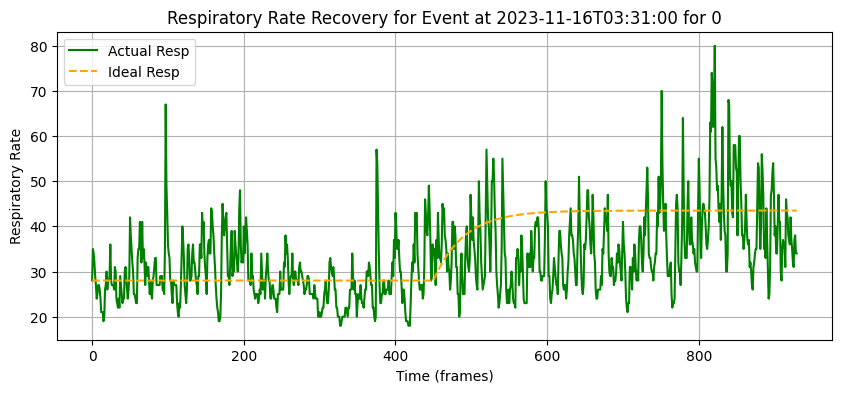


Errors for event at 2023-11-16T03:31:00:
  HR SSE: 124865.66, HR Signed Error: 5205.17
  RESP SSE: 80174.32, RESP Signed Error: -2353.15
converting time data type
finished converting, extracting baselien data now
baseline is: 128.61623763891055
Extracted Baseline


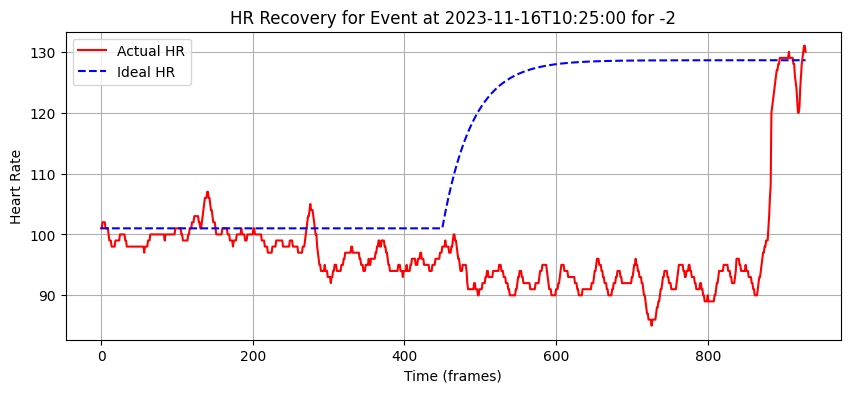

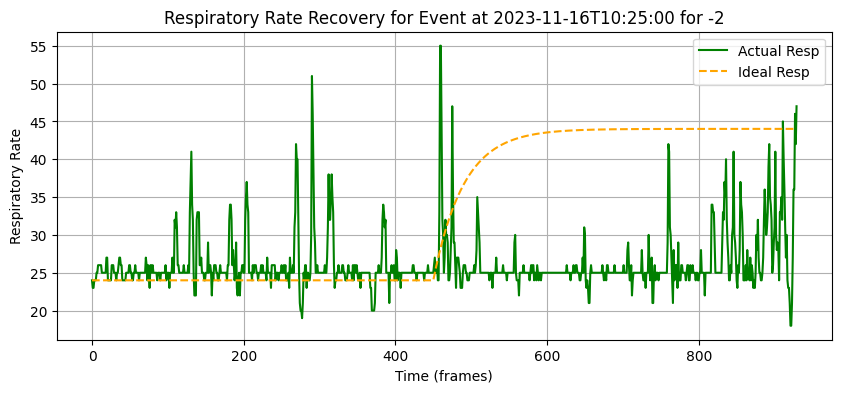


Errors for event at 2023-11-16T10:25:00:
  HR SSE: 509251.34, HR Signed Error: -15756.29
  RESP SSE: 144869.46, RESP Signed Error: -6719.41
converting time data type
finished converting, extracting baselien data now
baseline is: 129.4251203611624
Extracted Baseline


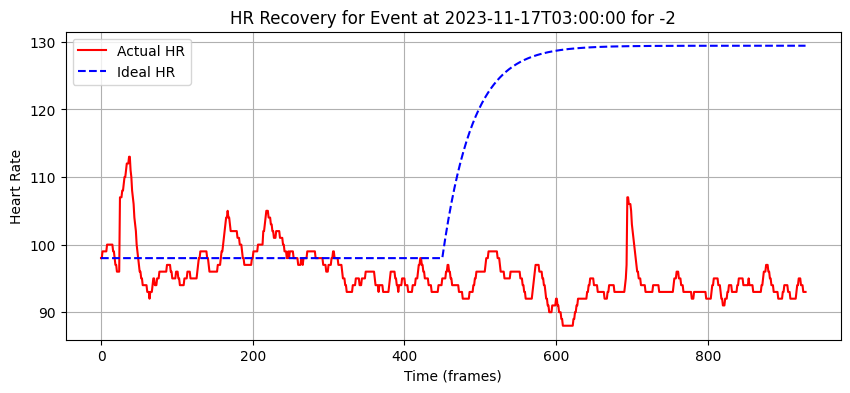

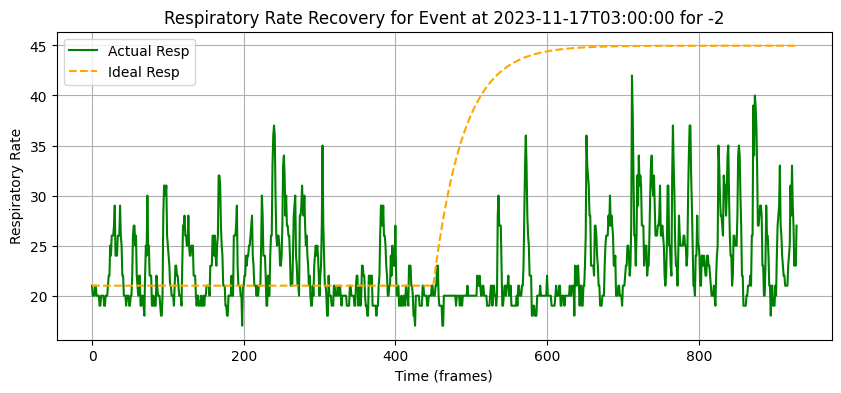


Errors for event at 2023-11-17T03:00:00:
  HR SSE: 548285.69, HR Signed Error: -16023.28
  RESP SSE: 201382.30, RESP Signed Error: -8690.74
converting time data type
finished converting, extracting baselien data now
baseline is: 129.83837667277623
Extracted Baseline


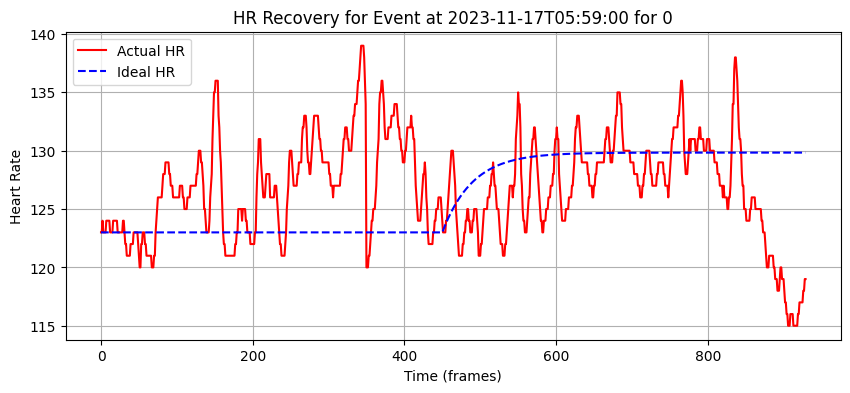

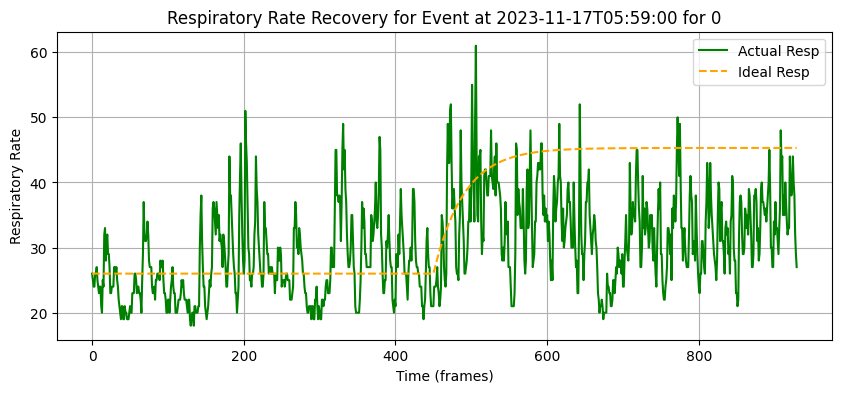


Errors for event at 2023-11-17T05:59:00:
  HR SSE: 27861.79, HR Signed Error: 527.55
  RESP SSE: 98074.02, RESP Signed Error: -4501.07
converting time data type
finished converting, extracting baselien data now
baseline is: 129.8732402067526
Extracted Baseline


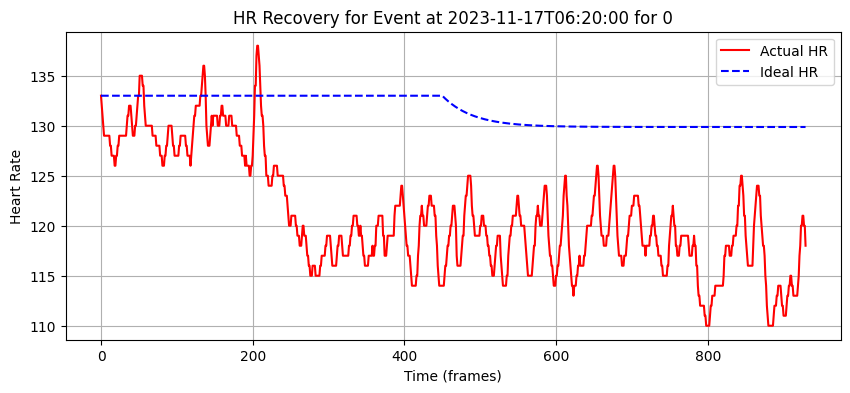

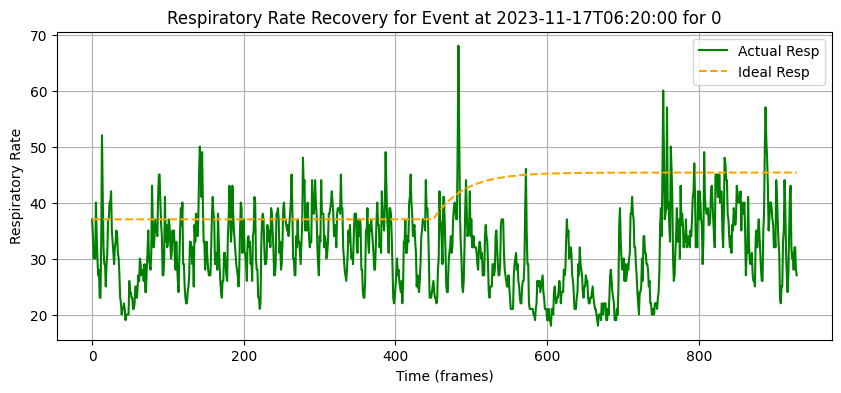


Errors for event at 2023-11-17T06:20:00:
  HR SSE: 127348.37, HR Signed Error: -9768.79
  RESP SSE: 147282.33, RESP Signed Error: -8612.32
converting time data type
finished converting, extracting baselien data now
baseline is: 129.8273558150969
Extracted Baseline


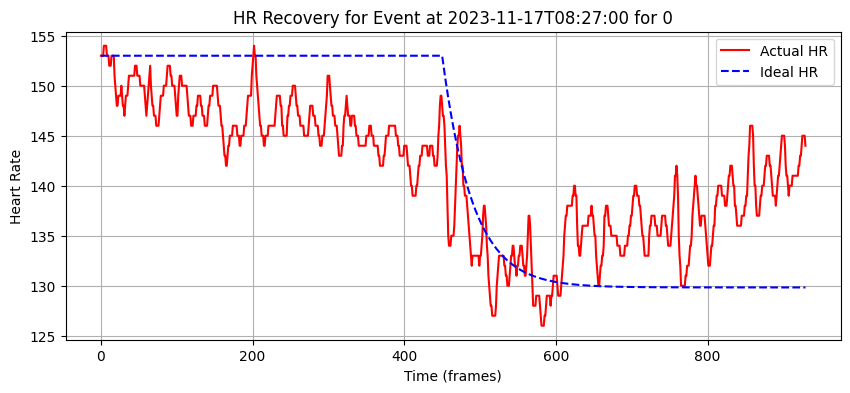

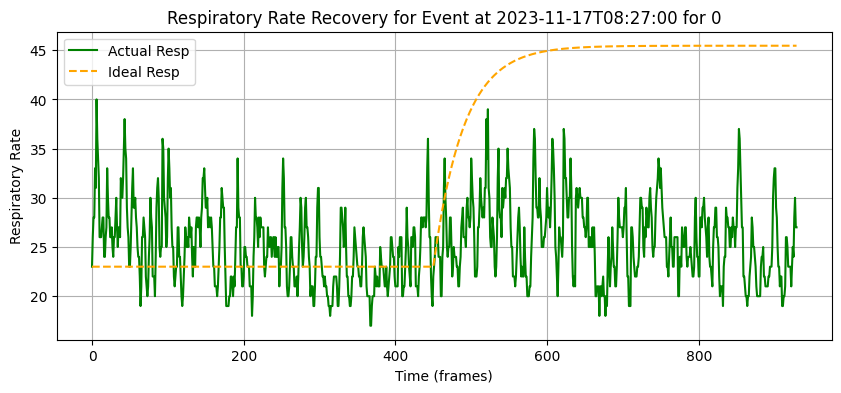


Errors for event at 2023-11-17T08:27:00:
  HR SSE: 46419.27, HR Signed Error: -705.67
  RESP SSE: 174828.16, RESP Signed Error: -7644.28
converting time data type
finished converting, extracting baselien data now
baseline is: 129.82757990092188
Extracted Baseline


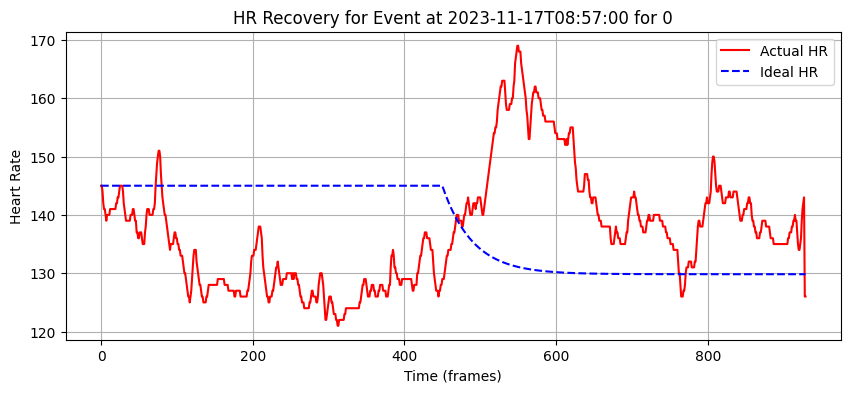

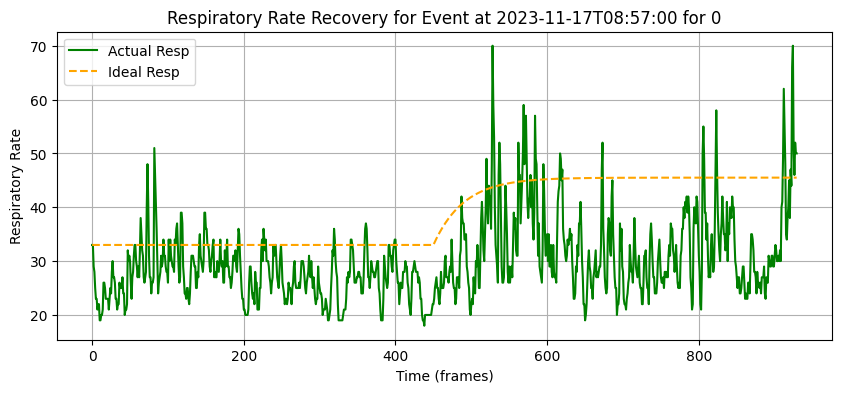


Errors for event at 2023-11-17T08:57:00:
  HR SSE: 223908.32, HR Signed Error: -527.75
  RESP SSE: 125552.10, RESP Signed Error: -8238.77
converting time data type
finished converting, extracting baselien data now
baseline is: 129.88062287703943
Extracted Baseline


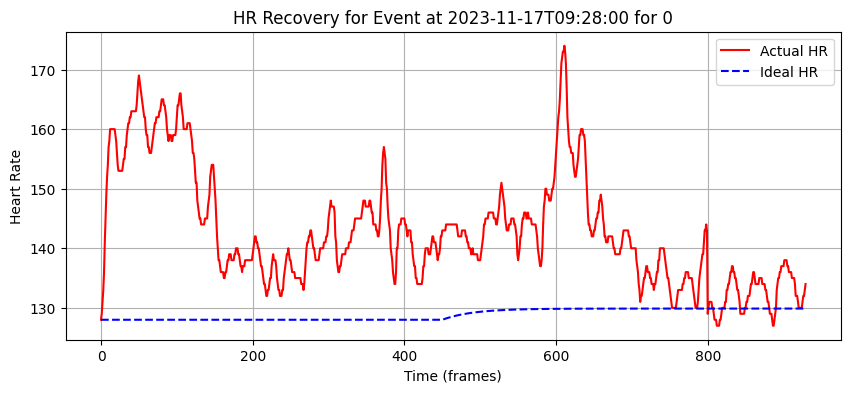

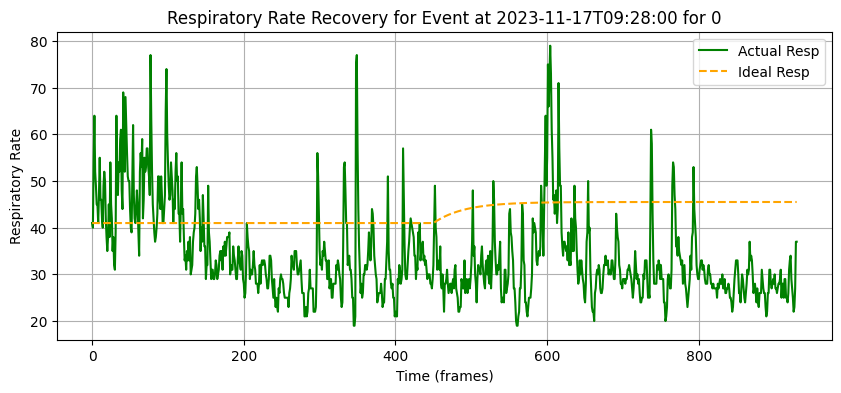


Errors for event at 2023-11-17T09:28:00:
  HR SSE: 272765.94, HR Signed Error: 12993.47
  RESP SSE: 178009.61, RESP Signed Error: -8411.57
converting time data type
finished converting, extracting baselien data now
baseline is: 130.0368263898763
Extracted Baseline


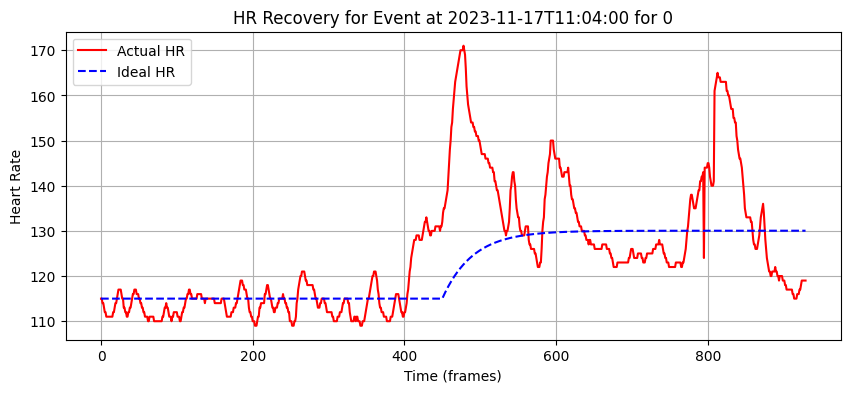

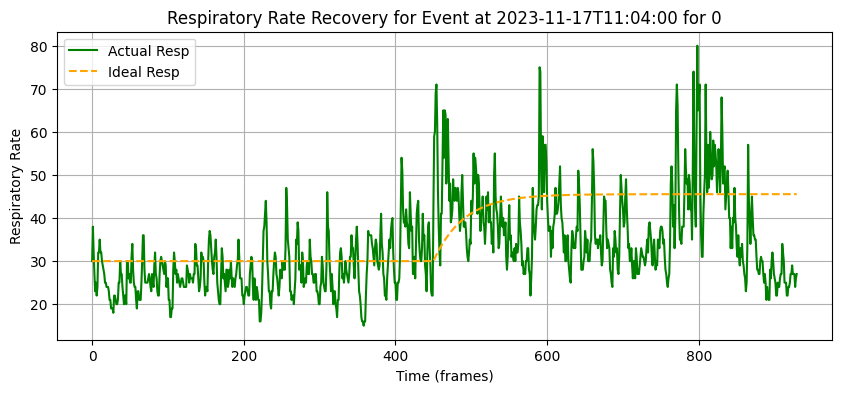


Errors for event at 2023-11-17T11:04:00:
  HR SSE: 137247.95, HR Signed Error: 2919.34
  RESP SSE: 102190.10, RESP Signed Error: -3773.62
converting time data type
finished converting, extracting baselien data now
baseline is: 130.00134270018665
Extracted Baseline


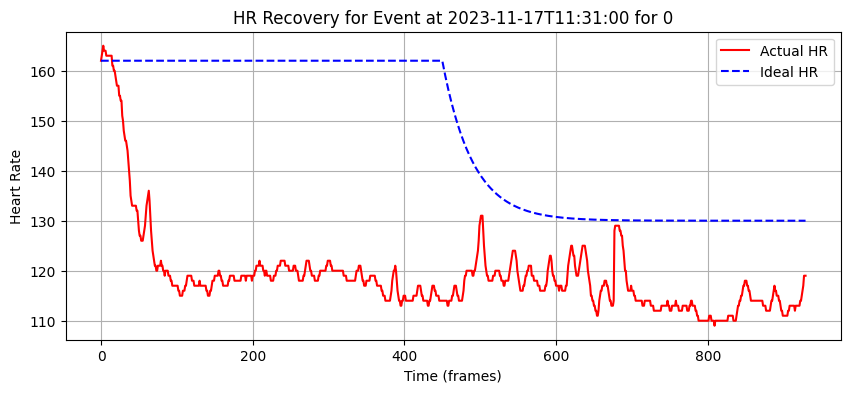

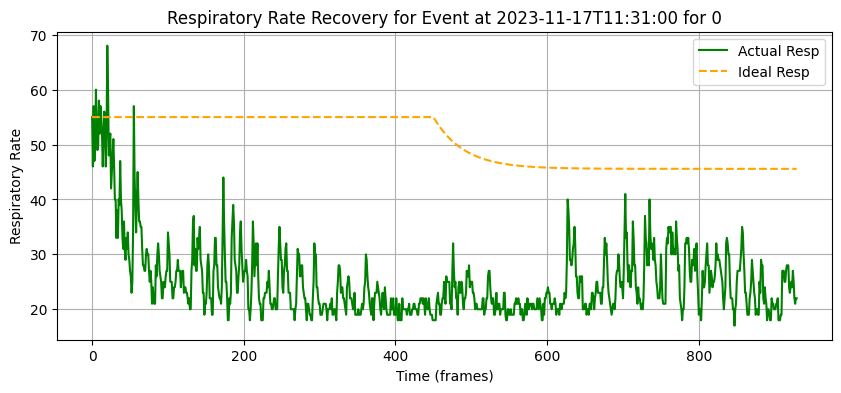


Errors for event at 2023-11-17T11:31:00:
  HR SSE: 924832.37, HR Signed Error: -25871.65
  RESP SSE: 651128.04, RESP Signed Error: -23502.65
converting time data type
finished converting, extracting baselien data now
baseline is: 129.98620190263605
Extracted Baseline


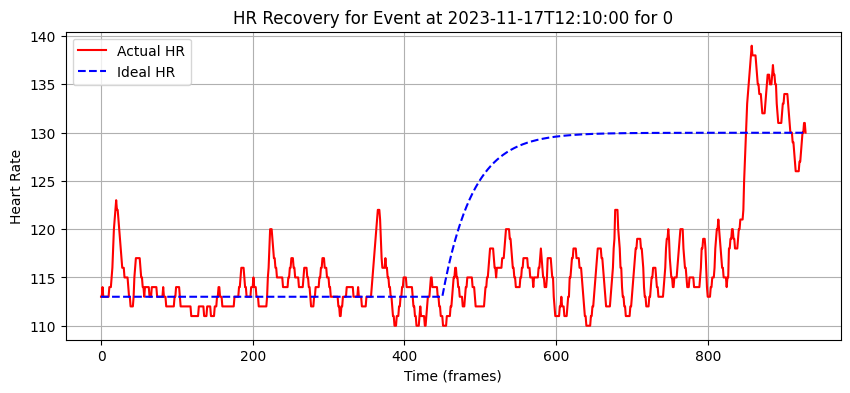

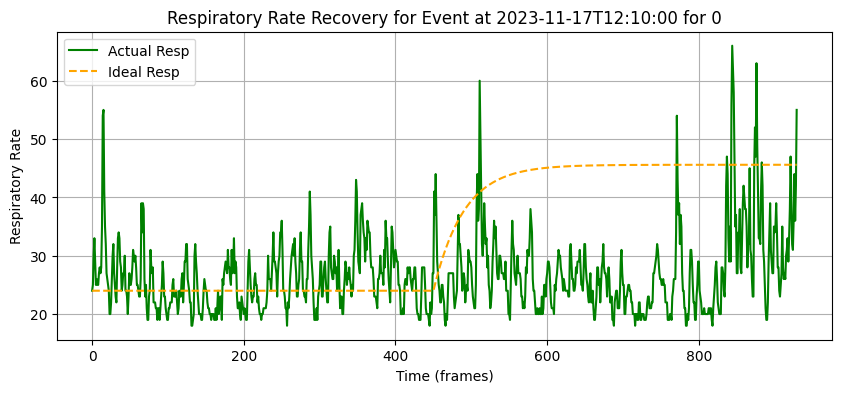


Errors for event at 2023-11-17T12:10:00:
  HR SSE: 77303.56, HR Signed Error: -4641.40
  RESP SSE: 176453.52, RESP Signed Error: -6995.62
converting time data type
finished converting, extracting baselien data now
baseline is: 130.05993470149255
Extracted Baseline


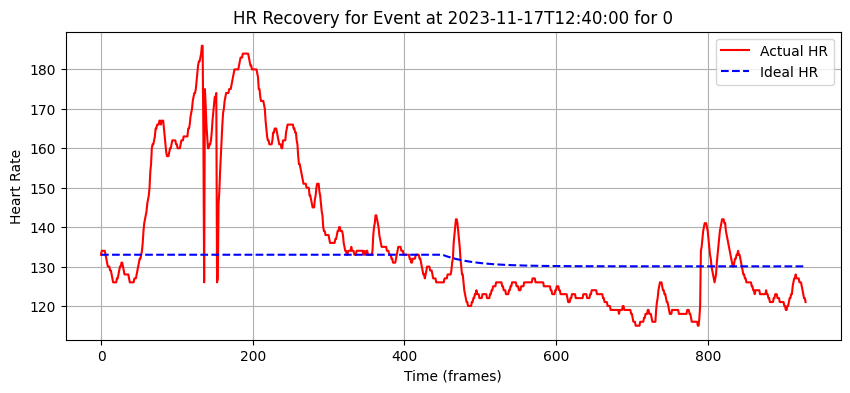

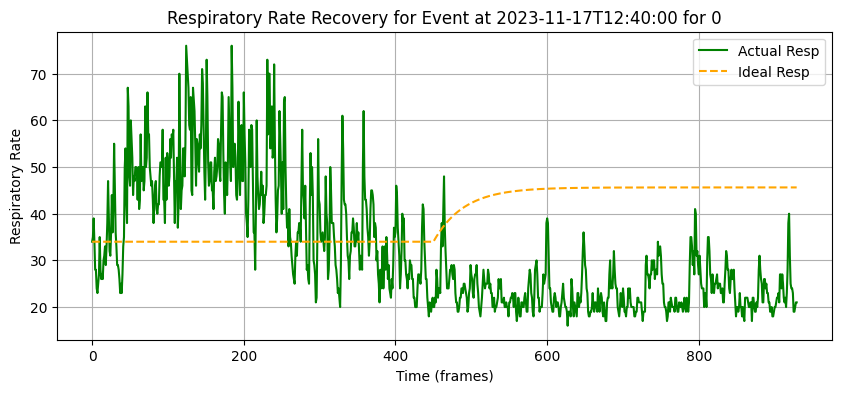


Errors for event at 2023-11-17T12:40:00:
  HR SSE: 305768.09, HR Signed Error: 4394.15
  RESP SSE: 328620.00, RESP Signed Error: -6735.72
converting time data type
finished converting, extracting baselien data now
baseline is: 130.11953002436664
Extracted Baseline


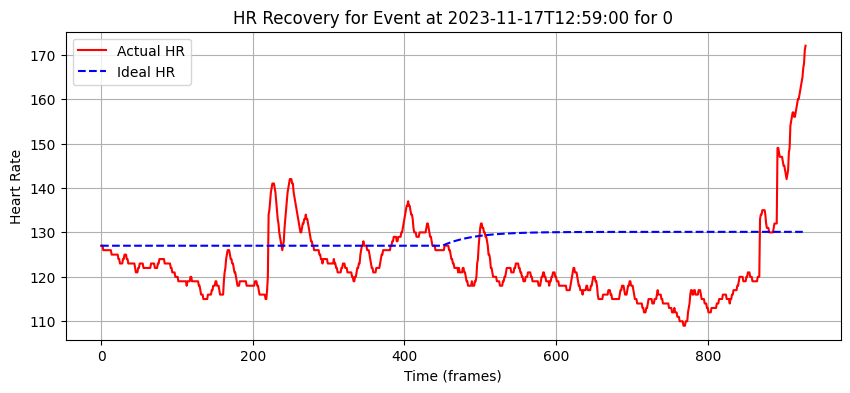

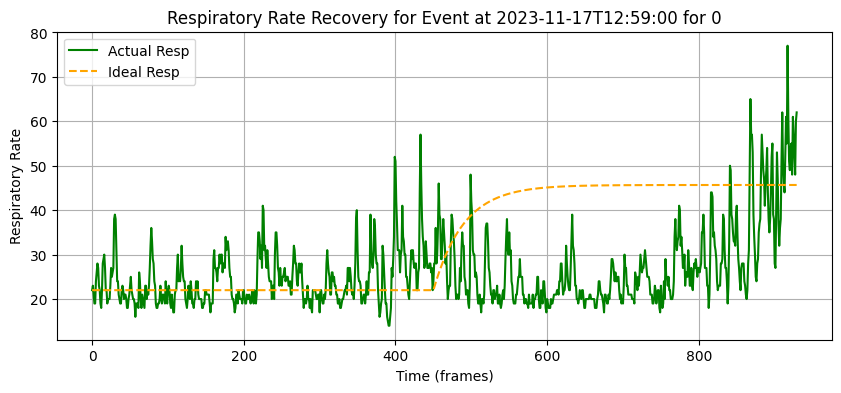


Errors for event at 2023-11-17T12:59:00:
  HR SSE: 109890.45, HR Signed Error: -5101.03
  RESP SSE: 194618.93, RESP Signed Error: -6549.75
converting time data type
finished converting, extracting baselien data now
baseline is: 130.7666672680366
Extracted Baseline


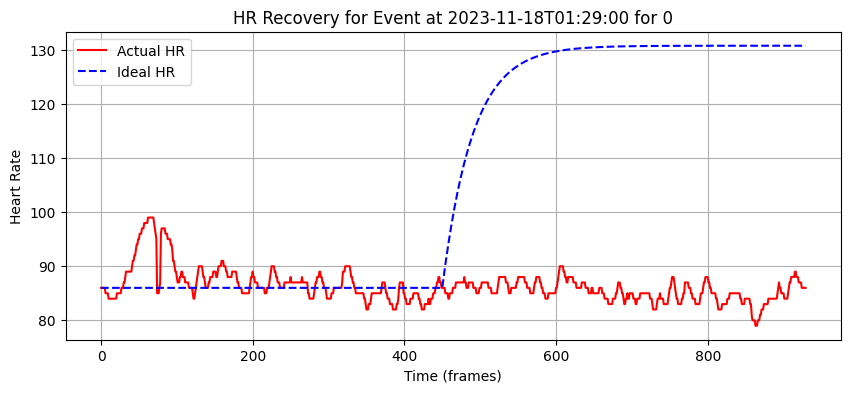

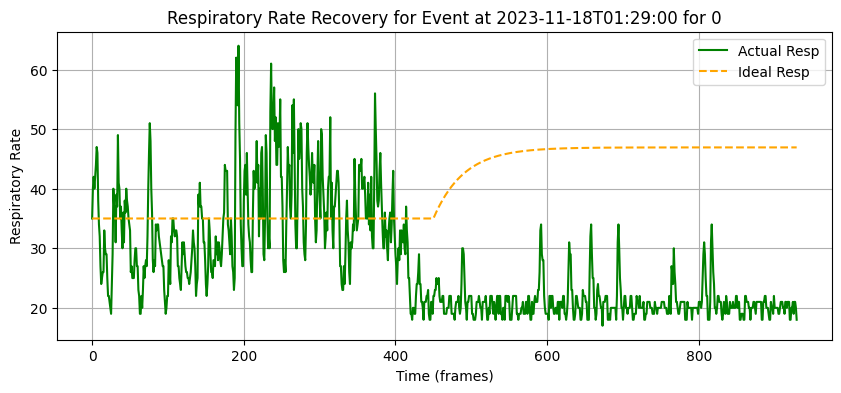


Errors for event at 2023-11-18T01:29:00:
  HR SSE: 880526.21, HR Signed Error: -19417.87
  RESP SSE: 342385.66, RESP Signed Error: -12558.15
converting time data type
finished converting, extracting baselien data now
baseline is: 130.7894166862855
Extracted Baseline


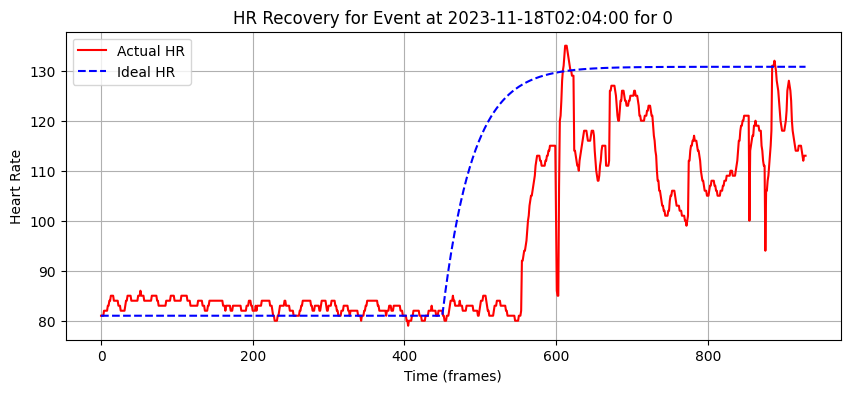

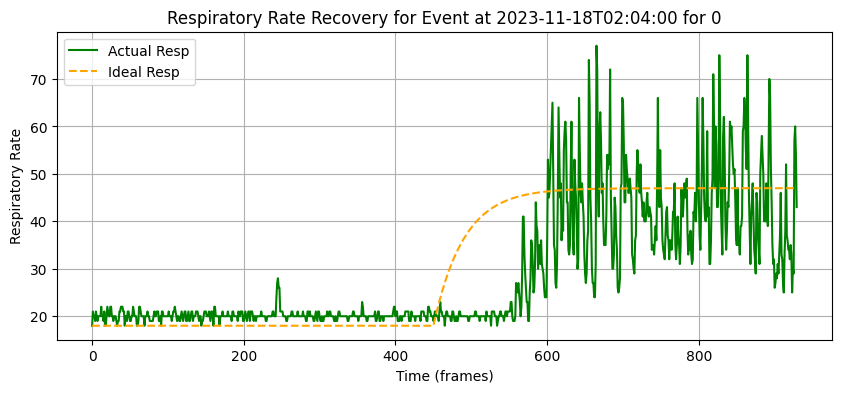


Errors for event at 2023-11-18T02:04:00:
  HR SSE: 246687.61, HR Signed Error: -8448.36
  RESP SSE: 96534.57, RESP Signed Error: -2723.95
converting time data type
finished converting, extracting baselien data now
baseline is: 130.96546438067296
Extracted Baseline


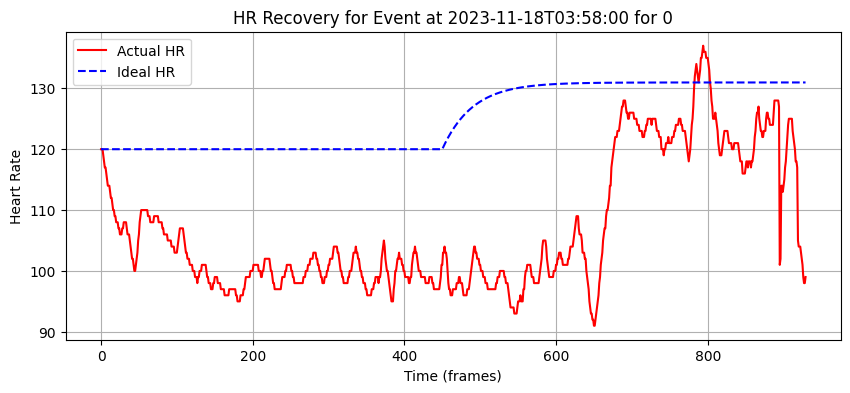

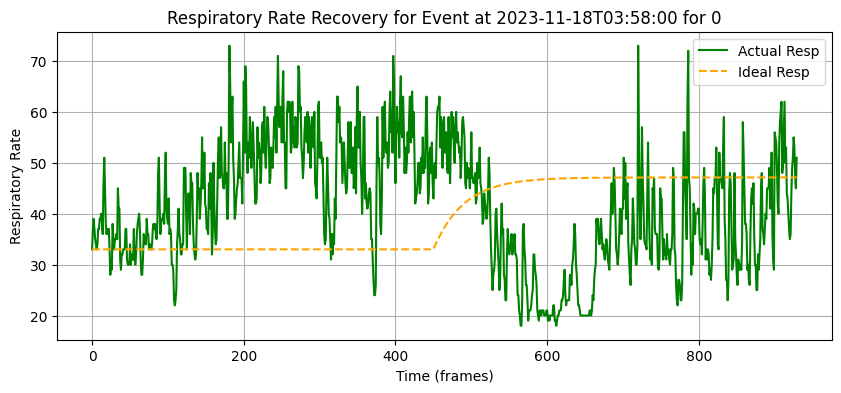


Errors for event at 2023-11-18T03:58:00:
  HR SSE: 387351.20, HR Signed Error: -17022.30
  RESP SSE: 246496.41, RESP Signed Error: 1591.98
converting time data type
finished converting, extracting baselien data now
baseline is: 130.962155253848
Extracted Baseline


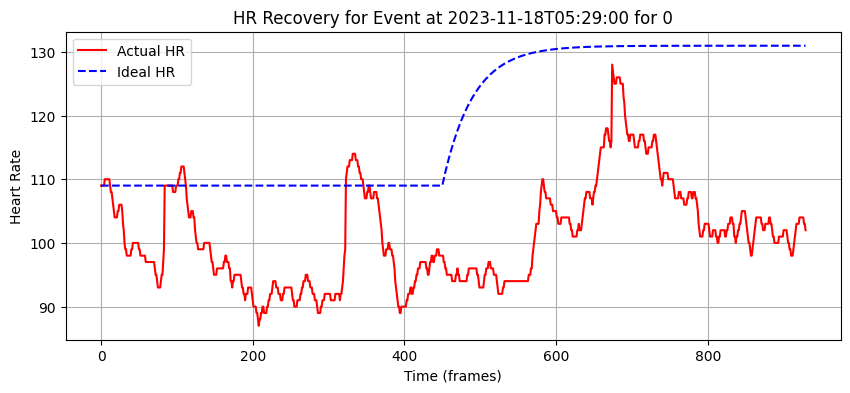

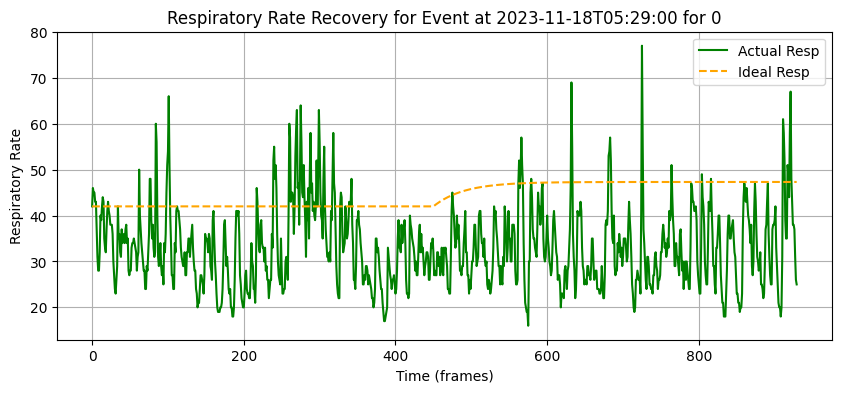


Errors for event at 2023-11-18T05:29:00:
  HR SSE: 400110.18, HR Signed Error: -16907.33
  RESP SSE: 198726.44, RESP Signed Error: -10583.65
converting time data type
finished converting, extracting baselien data now
baseline is: 131.1891549737547
Extracted Baseline


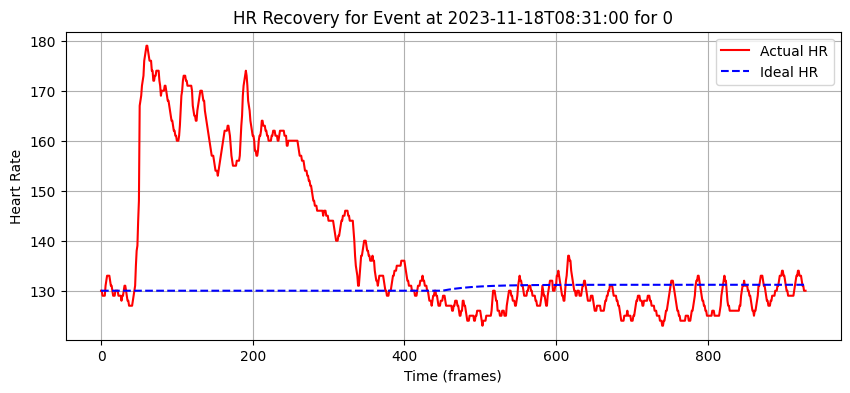

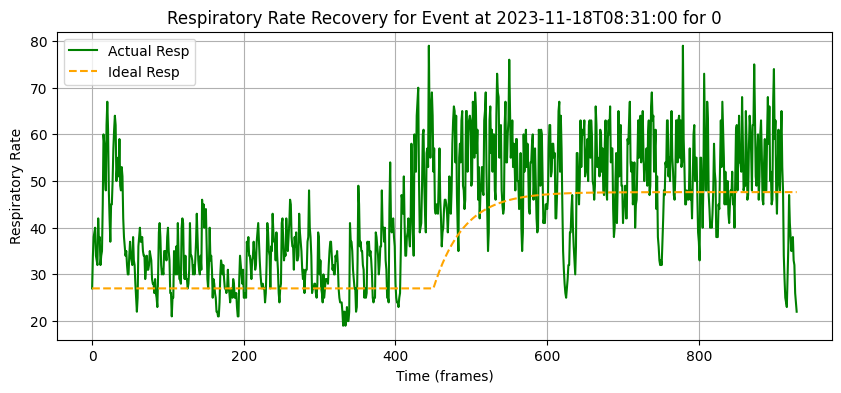


Errors for event at 2023-11-18T08:31:00:
  HR SSE: 288340.45, HR Signed Error: 7362.37
  RESP SSE: 141513.67, RESP Signed Error: 6336.29
converting time data type
finished converting, extracting baselien data now
baseline is: 131.21703041362068
Extracted Baseline


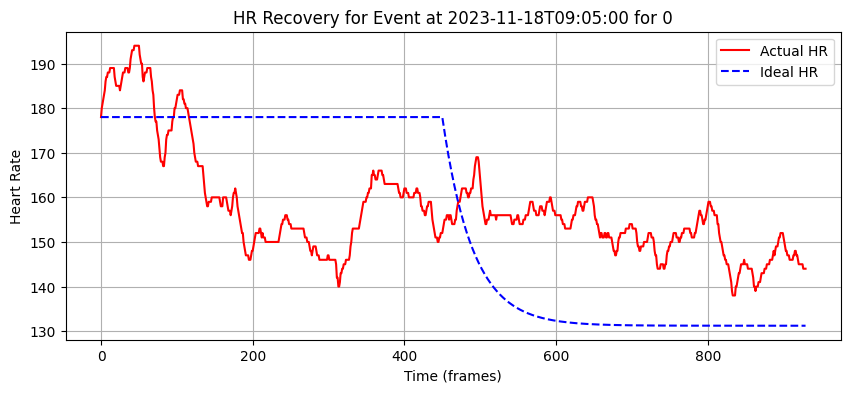

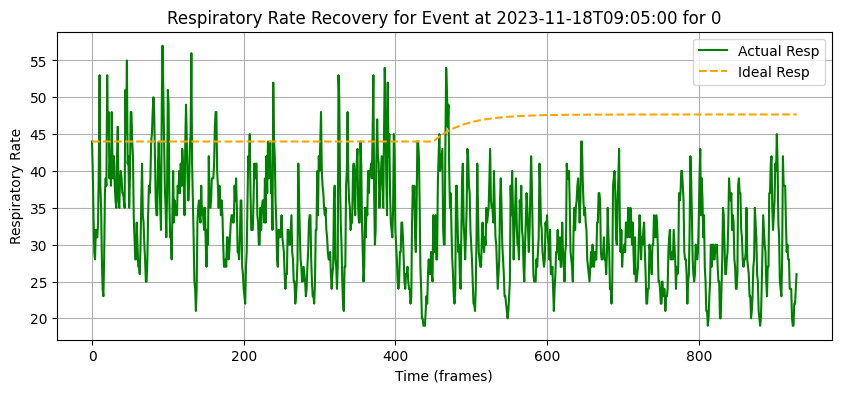


Errors for event at 2023-11-18T09:05:00:
  HR SSE: 370816.70, HR Signed Error: 1448.03
  RESP SSE: 216934.11, RESP Signed Error: -12277.32
converting time data type
finished converting, extracting baselien data now
baseline is: 131.68169581992825
Extracted Baseline


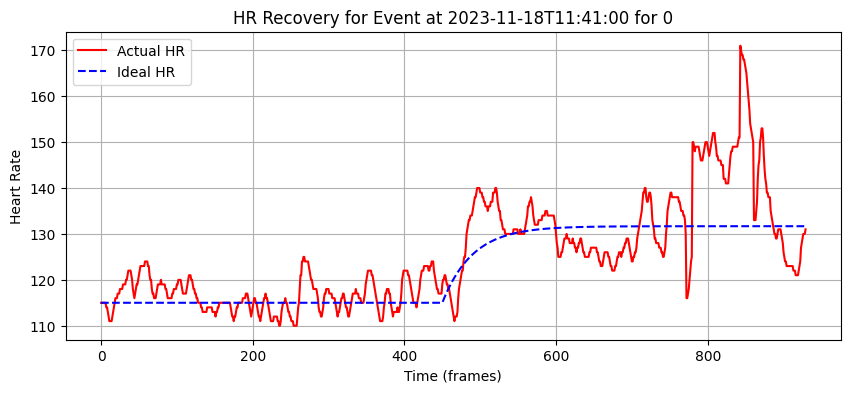

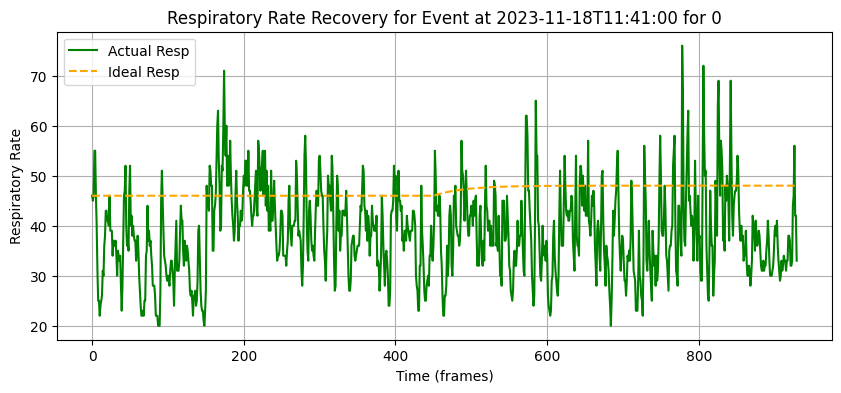


Errors for event at 2023-11-18T11:41:00:
  HR SSE: 57581.21, HR Signed Error: 2218.43
  RESP SSE: 135841.96, RESP Signed Error: -7678.06
converting time data type
finished converting, extracting baselien data now
baseline is: 131.76153101525594
Extracted Baseline


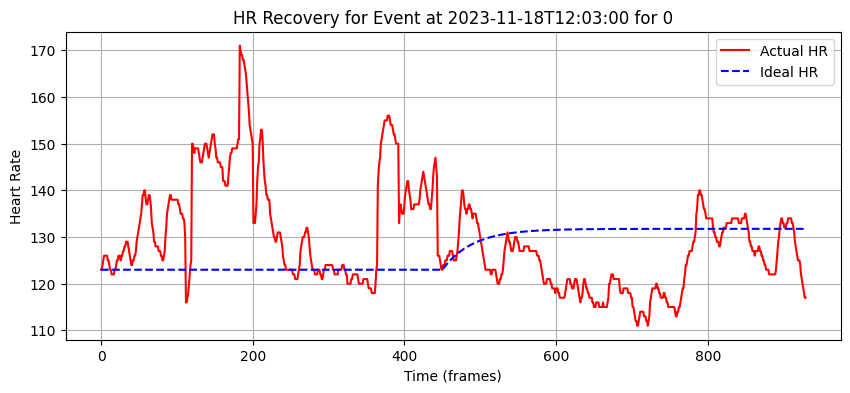

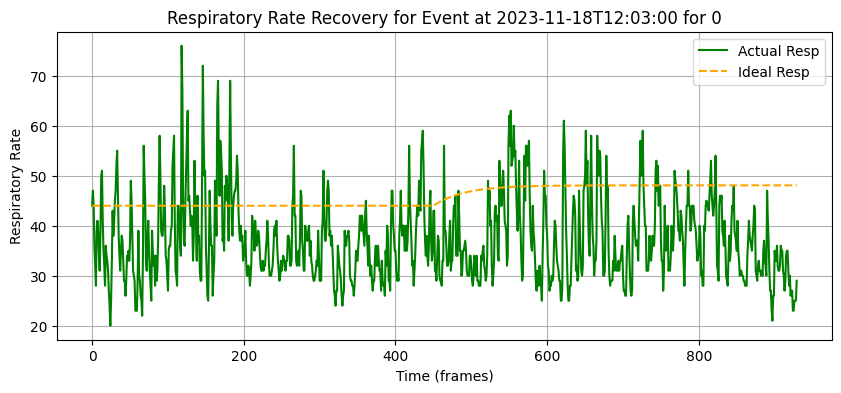


Errors for event at 2023-11-18T12:03:00:
  HR SSE: 172896.13, HR Signed Error: 2034.32
  RESP SSE: 135833.78, RESP Signed Error: -7968.89
converting time data type
finished converting, extracting baselien data now
baseline is: 132.38277036391716
Extracted Baseline


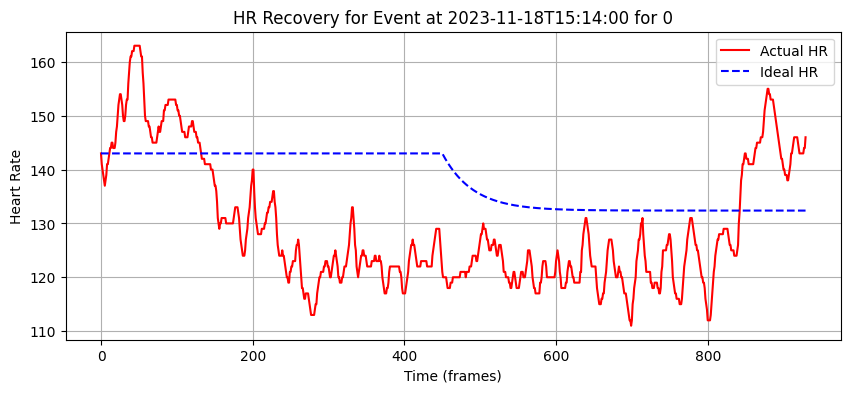

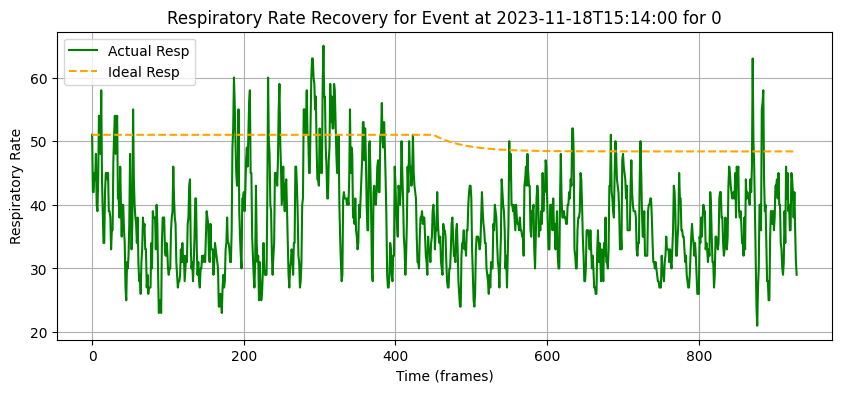


Errors for event at 2023-11-18T15:14:00:
  HR SSE: 198983.57, HR Signed Error: -8144.75
  RESP SSE: 188334.70, RESP Signed Error: -11214.71
converting time data type
finished converting, extracting baselien data now
baseline is: 132.43833127956432
Extracted Baseline


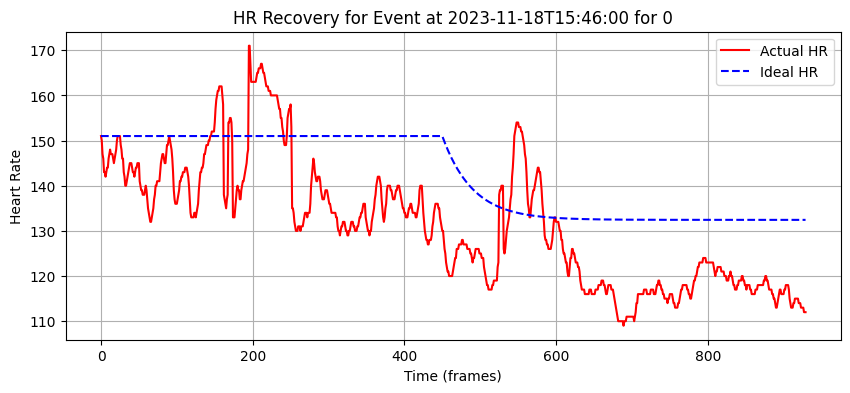

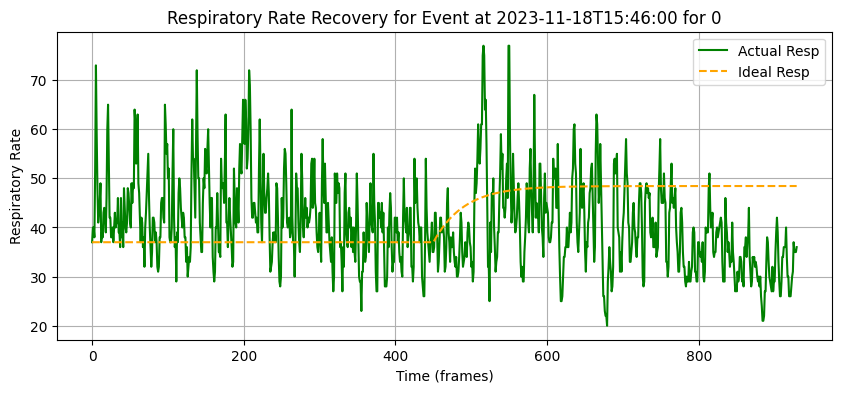


Errors for event at 2023-11-18T15:46:00:
  HR SSE: 192116.10, HR Signed Error: -9984.18
  RESP SSE: 123331.89, RESP Signed Error: -1392.05
converting time data type
finished converting, extracting baselien data now
baseline is: 132.83341985537874
Extracted Baseline


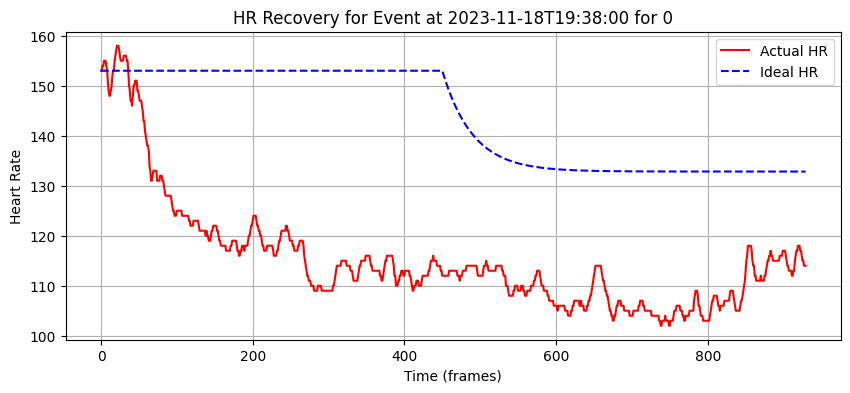

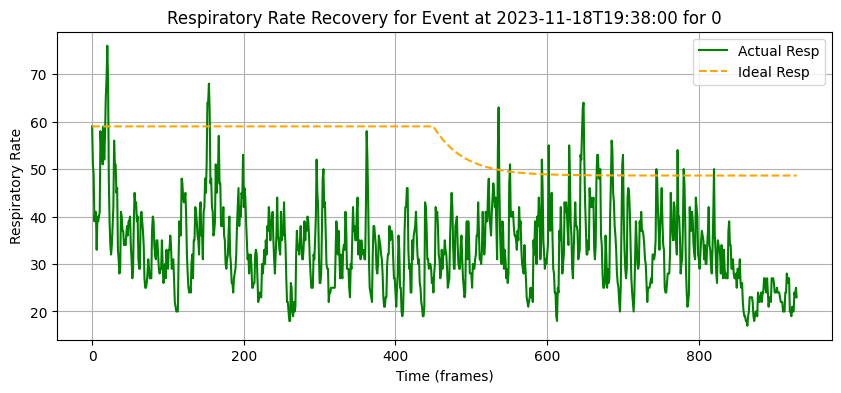


Errors for event at 2023-11-18T19:38:00:
  HR SSE: 827057.74, HR Signed Error: -26133.83
  RESP SSE: 476008.94, RESP Signed Error: -18998.81
converting time data type
finished converting, extracting baselien data now
baseline is: 132.78598526016182
Extracted Baseline


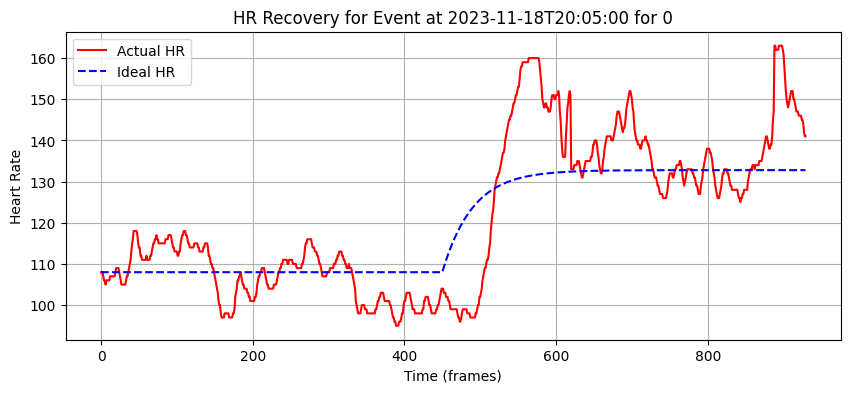

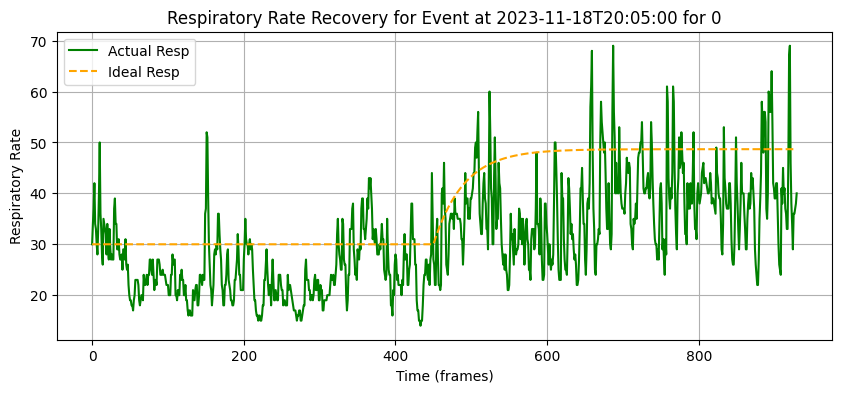


Errors for event at 2023-11-18T20:05:00:
  HR SSE: 111125.81, HR Signed Error: 1406.60
  RESP SSE: 114788.29, RESP Signed Error: -7038.27
converting time data type
finished converting, extracting baselien data now
baseline is: 132.61245673299206
Extracted Baseline


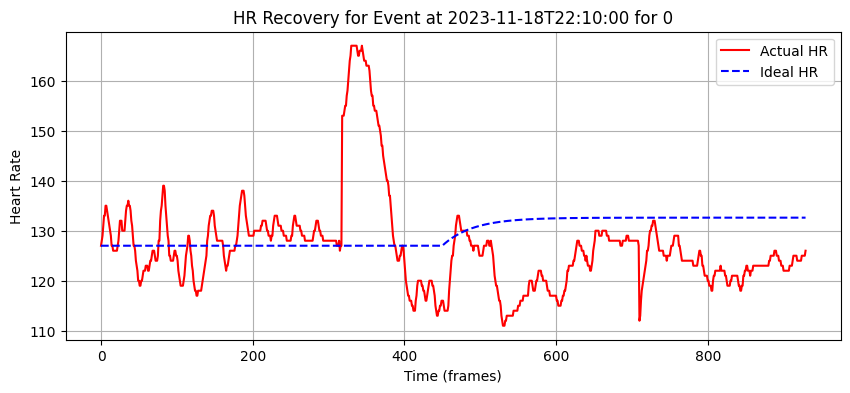

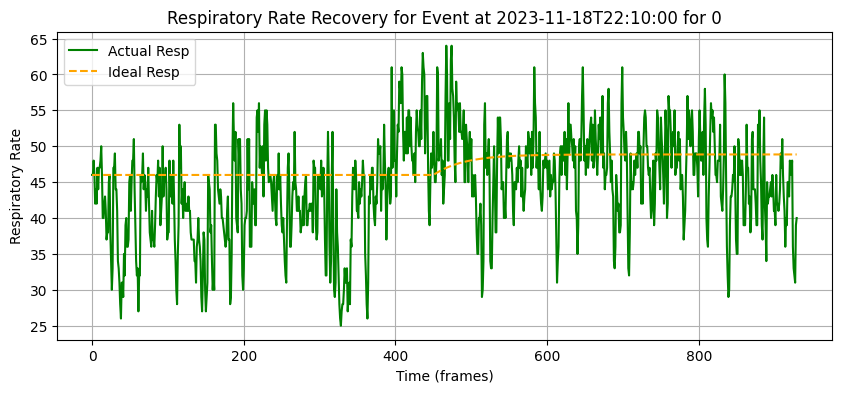


Errors for event at 2023-11-18T22:10:00:
  HR SSE: 123662.99, HR Signed Error: -2546.66
  RESP SSE: 50093.36, RESP Signed Error: -2513.11
converting time data type
finished converting, extracting baselien data now
baseline is: 132.5979355562157
Extracted Baseline


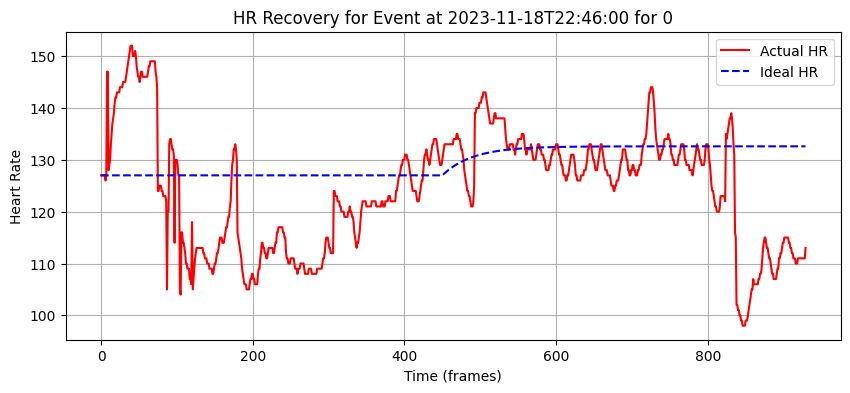

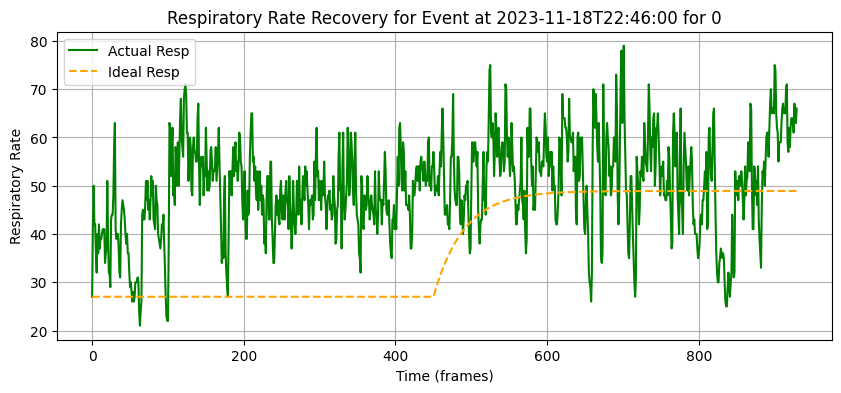


Errors for event at 2023-11-18T22:46:00:
  HR SSE: 148630.66, HR Signed Error: -4868.28
  RESP SSE: 284721.86, RESP Signed Error: 11502.23
converting time data type
finished converting, extracting baselien data now
baseline is: 132.69702950964412
Extracted Baseline


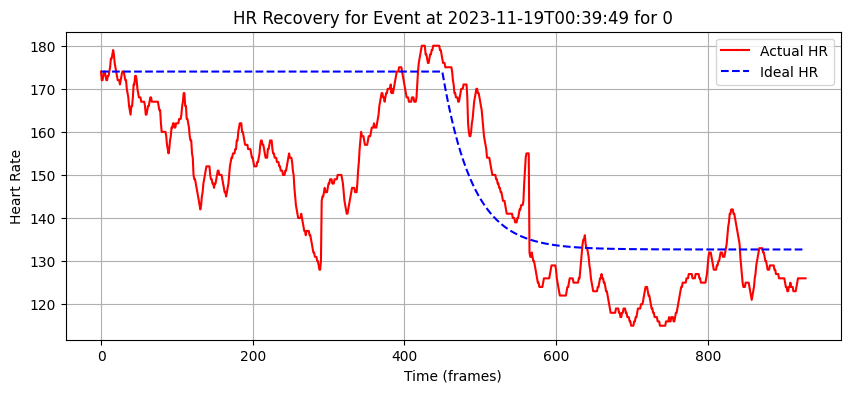

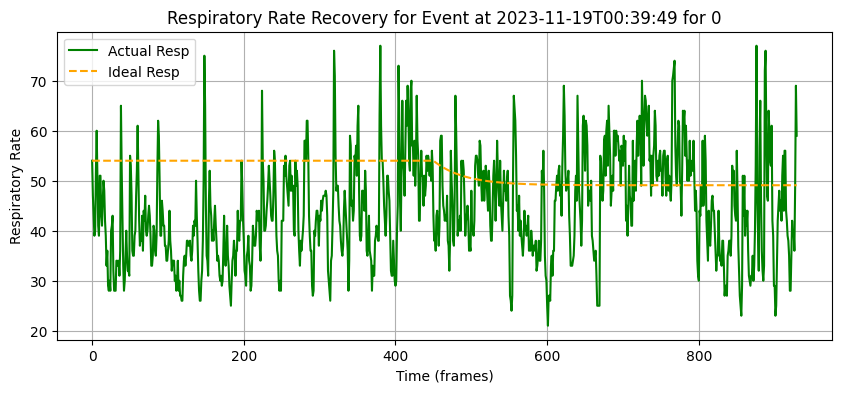


Errors for event at 2023-11-19T00:39:49:
  HR SSE: 223367.86, HR Signed Error: -8472.42
  RESP SSE: 165086.45, RESP Signed Error: -6840.31
converting time data type
finished converting, extracting baselien data now
baseline is: 133.22877584034177
Extracted Baseline


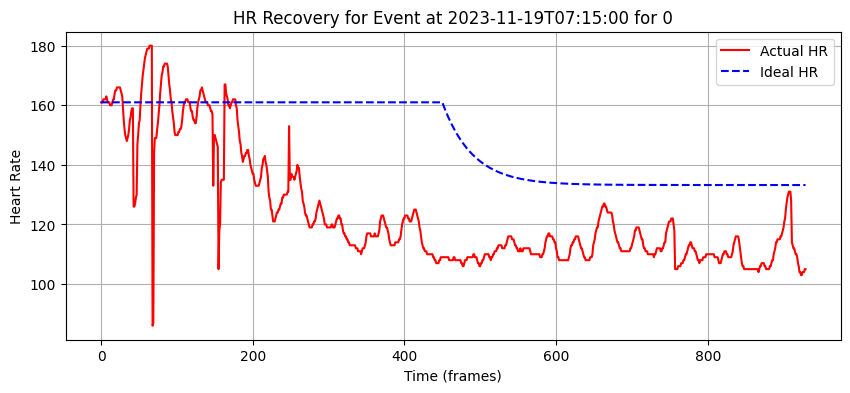

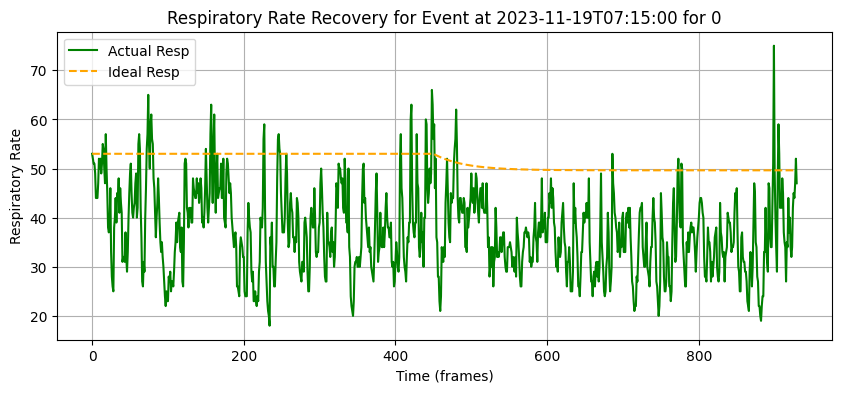


Errors for event at 2023-11-19T07:15:00:
  HR SSE: 762257.27, HR Signed Error: -22385.60
  RESP SSE: 248664.07, RESP Signed Error: -13032.82


In [40]:
from dateutil.parser import parse

#Place MAD data into SBS groups
data_dir = '/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data'
window_size = 100 # 100 is 1 second worth of time

lead_time = 1
slice_size_min = 31

Tag = "Retro"

#Retrospective
for patient in os.listdir(data_dir):
    print(patient)
    if 'DS' in patient:
        continue
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):

        #Vitals Data
        vitals_file_path = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_{Tag}.mat')
        if not os.path.isfile(vitals_file_path):
            continue
        vitals_data = loadmat(vitals_file_path)
        hr = vitals_data["heart_rate"]

        # time = vitals_data['start_time'].flatten()
        sbs = vitals_data['sbs'].flatten()
        x_mag = vitals_data["x_mag"]
        retro_PRN = vitals_data['PRNs'].flatten()
        resp = vitals_data["respiratory_rate"]
        times_sbs = vitals_data['start_time'].flatten()

        # Remove all white spaces from each string
        retro_PRN = [s.replace(" ", "") for s in retro_PRN]

        Times = []

    for i in range(len(sbs) - 1):
        if (retro_PRN[i] == 'Y') and (np.mean(resp[i]) != 0):
            TIME = times_sbs[i]
            
            # Get baseline from 12 hours before this score
            hr_baseline, resp_baseline = extract_baseline(patient_dir, patient, TIME)
            print(f'baseline is: {hr_baseline}')       
            print('Extracted Baseline')
            # Time axis
            t = np.arange(len(hr[i]))

            # Ideal recovery curves
            ideal_values_hr = delayed_exponential_decay(t, hr[i][0], hr_baseline, t0=450, rate=-0.025)      #450 for 15 minutes delayed effect 
            ideal_values_resp = delayed_exponential_decay(t, resp[i][0], resp_baseline, t0=450, rate=-0.025)          

            # Actual values
            actual_values_hr = np.array(hr[i])
            assert(len(ideal_values_hr) == len(actual_values_hr))
            actual_values_resp = np.array(resp[i])

            # Plot HR
            plt.figure(figsize=(10, 4))
            plt.plot(t, actual_values_hr, label='Actual HR', color='red')
            plt.plot(t, ideal_values_hr, label='Ideal HR', color='blue', linestyle='--')
            plt.title(f"HR Recovery for Event at {TIME} for {sbs[i]}")
            plt.xlabel("Time (frames)")
            plt.ylabel("Heart Rate")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot RESP
            plt.figure(figsize=(10, 4))
            plt.plot(t, actual_values_resp, label='Actual Resp', color='green')
            plt.plot(t, ideal_values_resp, label='Ideal Resp', color='orange', linestyle='--')
            plt.title(f"Respiratory Rate Recovery for Event at {TIME} for {sbs[i]}")
            plt.xlabel("Time (frames)")
            plt.ylabel("Respiratory Rate")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Compute errors
            hr_sse = np.sum((actual_values_hr - ideal_values_hr)**2)
            hr_signed_error = np.sum(actual_values_hr - ideal_values_hr)

            resp_sse = np.sum((actual_values_resp - ideal_values_resp)**2)
            resp_signed_error = np.sum(actual_values_resp - ideal_values_resp)

            print(f"\nErrors for event at {TIME}:")
            print(f"  HR SSE: {hr_sse:.2f}, HR Signed Error: {hr_signed_error:.2f}")
            print(f"  RESP SSE: {resp_sse:.2f}, RESP Signed Error: {resp_signed_error:.2f}")




   